# MACHINE LEARNING: Churn customers with Python
#### Autora: María Luisa Duque (mlduque)
#### E-mail: marialdu@ucm.es
#### LinkedIn: https://www.linkedin.com/in/marialuisaduque/
#### Github: https://github.com/mlduque

El presente caso práctico consiste en calcular el churn de clientes en una empresa de telecomunicaciones. La compañía ha 
descubierto que entre diciembre de 2019 y enero de 2020 han tenido bastantes bajas de clientes.
El objetivo es llegar a construir un modelo analítico que sea capaz de predecir los próximos clientes que son potenciales
a marcharse de la operadora para poder lanzar una campaña e intentar fidelizarles antes de su portabilidad.
Además, se tratará de conocer las causas por las cuales los clientes se están fugando.

Los datasets de los que disponemos son 4 tablas tanto para el mes de diciembre 2019 como para el mes de enero de 2020:
    
    - TABLA DE CLIENTES
    - TABLA DE PRODUCTOS
    - TABLA CONSUMOS
    - TABLA FINANCIACIÓN
    
La variable 'id' es el identificador de cliente, común a todas las tablas

Para el desarrollo del presente análisis vamos a seguir los siguientes pasos:

    Apartado 1) Carga de los dataset y construir un único tablón analítico con todas las variables consideradas necesarias.
    Aparatdo 2) Realización de preprocesado y limpieza de datos
    Apartado 3) Muestreo Aleatorio Estratificado: conjuntos train y test
    Apartado 4) Construcción de un modelo analítico de clasificación: Regresión Logística
    Apartado 5) Mejora del modelo de clasificación
    Apartado 6) Predicción
    Apartado 7) Conclusiones y claves a porqué los clientes se marchan de la compañía

### Apartado 1) Carga de los dataset y construir un único tablón analítico con todas las variables consideradas necesarias

In [1726]:
# Cargamos las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from scipy import stats
from datetime import date
from datetime import datetime
from datetime import date
from sklearn.datasets import make_classification
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import naive_bayes
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2 
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import statsmodels.formula.api as smf
import pickle

In [1727]:
# Cargamos todos los datasets, tanto como para diciembre como para enero
df_clientesdic = pd.read_csv('clientes_diciembre.csv', sep='|') # Tabla máster de diciembre
df_consumosdic = pd.read_csv('consumos_diciembre.csv', sep='|') 
df_financiaciondic = pd.read_csv('financiacion_diciembre.csv', sep='|') 
df_productosdic = pd.read_csv('productos_diciembre.csv', sep='|') 

df_clientesene = pd.read_csv('clientes_enero.csv', sep='|')   # Tabla máster de enero
df_consumosene = pd.read_csv('consumos_enero.csv', sep='|') 
df_financiacionene = pd.read_csv('financiacion_enero.csv', sep='|') 
df_productosene = pd.read_csv('productos_enero.csv', sep='|') 

df_clientesdic.head()

,id,edad,facturacion,antiguedad,provincia,num_lineas,num_dt,incidencia
0,1,63,216.028109,11/23/2018 08:48 AM,La Rioja,5,NaN,NaN
1,2,84,255.830842,08/22/2017 03:19 AM,Vizcaya,3,NaN,NaN
2,3,66,135.768153,12/27/2001 01:50 PM,Albacete,4,NaN,NaN
3,4,69,255.658527,08/08/2015 10:53 AM,Lugo,4,NaN,NaN
4,5,25,22.302845,08/29/1997 02:19 AM,Tarragona,2,2.0,NaN


In [1728]:
# Construcción de un único tablón analítico, mergeamos las tablas para diciembre y enero por su key 'id'
dfdic1 = pd.merge(df_clientesdic,df_consumosdic, on='id',how='outer', indicator=False)
dfdic1.head()

,id,edad,facturacion,antiguedad,provincia,num_lineas,num_dt,incidencia,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal
0,1,63,216.028109,11/23/2018 08:48 AM,La Rioja,5,NaN,NaN,110,79,10897,12806,13751
1,2,84,255.830842,08/22/2017 03:19 AM,Vizcaya,3,NaN,NaN,189,89,18657,6499,10862
2,3,66,135.768153,12/27/2001 01:50 PM,Albacete,4,NaN,NaN,129,30,15511,17013,16743
3,4,69,255.658527,08/08/2015 10:53 AM,Lugo,4,NaN,NaN,51,52,12670,3393,6771
4,5,25,22.302845,08/29/1997 02:19 AM,Tarragona,2,2.0,NaN,183,3,23756,18436,4485


In [1729]:
dfdic2 = pd.merge(dfdic1,df_financiaciondic, on='id',how='outer', indicator=False)
dfdic2.tail()

,id,edad,facturacion,antiguedad,provincia,num_lineas,num_dt,incidencia,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal,financiacion,imp_financ,descuentos
95462,99995,65,173.741667,03/05/2019 12:00 AM,Murcia,5,NaN,NaN,121,98,13403,6197,6853,SI,23.138779,NaN
95463,99996,36,215.890326,04/09/2013 01:33 PM,Guadalajara,3,NaN,NaN,98,13,5291,3684,1667,NaN,NaN,NaN
95464,99997,68,285.890750,08/08/2003 11:57 PM,Asturias,5,NaN,NaN,226,20,20002,572,5679,SI,14.616422,NaN
95465,99998,20,383.167610,03/27/2013 08:07 PM,Álava,4,NaN,NaN,126,26,16448,833,14398,NaN,NaN,NaN
95466,100000,18,57.158927,10/22/2009 07:17 PM,Las Palmas,4,NaN,NaN,85,25,17933,18617,2115,NaN,NaN,SI


In [1730]:
df_diciembre = pd.merge(dfdic2,df_productosdic, on='id',how='outer', indicator=False)
df_diciembre.tail()

,id,edad,facturacion,antiguedad,provincia,num_lineas,num_dt,incidencia,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal,financiacion,imp_financ,descuentos,conexion,vel_conexion,TV
95462,99995,65,173.741667,03/05/2019 12:00 AM,Murcia,5,NaN,NaN,121,98,13403,6197,6853,SI,23.138779,NaN,ADSL,35MB,tv-familiar
95463,99996,36,215.890326,04/09/2013 01:33 PM,Guadalajara,3,NaN,NaN,98,13,5291,3684,1667,NaN,NaN,NaN,ADSL,30MB,tv-futbol
95464,99997,68,285.890750,08/08/2003 11:57 PM,Asturias,5,NaN,NaN,226,20,20002,572,5679,SI,14.616422,NaN,FIBRA,200MB,tv-futbol
95465,99998,20,383.167610,03/27/2013 08:07 PM,Álava,4,NaN,NaN,126,26,16448,833,14398,NaN,NaN,NaN,ADSL,20MB,tv-futbol
95466,100000,18,57.158927,10/22/2009 07:17 PM,Las Palmas,4,NaN,NaN,85,25,17933,18617,2115,NaN,NaN,SI,ADSL,25MB,tv-familiar


In [1731]:
dfene1 = pd.merge(df_clientesene,df_consumosene, on='id',how='outer', indicator=False)
dfene2 = pd.merge(dfene1,df_financiacionene, on='id',how='outer', indicator=False)
df_enero = pd.merge(dfene2,df_productosene, on='id',how='outer', indicator=False)
df_enero.tail()

,id,edad,facturacion,antiguedad,provincia,num_lineas,num_dt,incidencia,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal,financiacion,imp_financ,descuentos,conexion,vel_conexion,TV
92706,99996,36,215.890326,04/09/2013 01:33 PM,Guadalajara,3,NaN,NaN,217,96,9059,7735,8823,NaN,NaN,NaN,ADSL,30MB,tv-futbol
92707,99997,68,285.890750,08/08/2003 11:57 PM,Asturias,5,NaN,NaN,168,99,9303,4798,3996,SI,14.616422,NaN,FIBRA,200MB,tv-futbol
92708,99998,20,383.167610,03/27/2013 08:07 PM,Álava,4,NaN,NaN,188,71,19018,1237,16720,NaN,NaN,NaN,ADSL,20MB,tv-futbol
92709,99999,53,53.301395,01/18/2020 02:30 AM,Sevilla,2,NaN,NaN,138,40,20264,10552,17637,NaN,NaN,NaN,FIBRA,50MB,tv-futbol
92710,100000,18,57.158927,10/22/2009 07:17 PM,Las Palmas,4,NaN,NaN,217,65,21772,14141,927,NaN,NaN,SI,ADSL,25MB,tv-familiar


### Aparatdo 2) Realización de preprocesado y limpieza de datos

Análisis de datos y preprocesado

In [1732]:
df_diciembre.shape

(95467, 19)

In [1733]:
df_enero.shape # En enero hay menor número de clientes, los que se han ido (cuidado que también puede haber nuevos clientes)

(92711, 19)

In [1734]:
df_diciembre.describe() # Vemos a nivel numérico las variables

,id,edad,facturacion,num_lineas,num_dt,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal,imp_financ
count,95467.000000,95467.000000,95467.000000,95467.000000,6517.000000,95467.000000,95467.000000,95467.000000,95467.000000,95467.000000,6372.000000
mean,49994.256832,51.462086,207.392912,3.558518,2.498082,124.815633,50.022762,12489.795898,9984.406612,10029.761342,22.268613
std,28873.008865,19.590846,111.343491,1.086095,1.121339,72.492338,29.119904,7239.421267,5763.182070,5763.518604,10.177659
min,1.000000,18.000000,15.000439,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.009999
25%,24997.500000,35.000000,111.383822,3.000000,1.000000,62.000000,25.000000,6177.500000,5006.000000,5055.000000,13.432253
50%,49970.000000,51.000000,206.808431,4.000000,3.000000,124.000000,50.000000,12466.000000,9965.000000,10024.000000,21.885534
75%,75021.500000,68.000000,304.436599,4.000000,4.000000,188.000000,75.000000,18785.500000,14969.000000,15007.000000,31.155292
max,100000.000000,85.000000,399.998433,5.000000,4.000000,250.000000,100.000000,25000.000000,20000.000000,20000.000000,39.990128


In [1735]:
df_enero.describe() 

,id,edad,facturacion,num_lineas,num_dt,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal,imp_financ
count,92711.000000,92711.000000,92711.000000,92711.000000,2614.000000,92711.000000,92711.000000,92711.000000,92711.000000,92711.000000,6666.000000
mean,49997.623626,51.429237,207.488700,3.560214,2.529457,125.109836,49.858960,12510.190495,9985.382781,10030.443960,22.272793
std,28863.150364,19.585913,111.239476,1.085810,1.123324,72.421075,29.208549,7217.671483,5774.903324,5786.754197,10.161969
min,1.000000,18.000000,15.000439,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.009999
25%,24963.500000,34.000000,111.368385,3.000000,2.000000,62.000000,25.000000,6232.500000,4960.000000,5010.000000,13.463536
50%,49999.000000,51.000000,207.089366,4.000000,3.000000,125.000000,50.000000,12526.000000,9998.000000,10037.000000,21.882572
75%,74990.500000,68.000000,304.349361,4.000000,4.000000,188.000000,75.000000,18742.000000,14981.000000,15036.000000,31.118611
max,100000.000000,85.000000,399.998433,5.000000,4.000000,250.000000,100.000000,25000.000000,20000.000000,20000.000000,39.991954


In [1736]:
df_diciembre.dtypes

id                  int64
edad                int64
facturacion       float64
antiguedad         object
provincia          object
num_lineas          int64
num_dt            float64
incidencia         object
num_llamad_ent      int64
num_llamad_sal      int64
mb_datos            int64
seg_llamad_ent      int64
seg_llamad_sal      int64
financiacion       object
imp_financ        float64
descuentos         object
conexion           object
vel_conexion       object
TV                 object
dtype: object

In [1737]:
df_enero.dtypes

id                  int64
edad                int64
facturacion       float64
antiguedad         object
provincia          object
num_lineas          int64
num_dt            float64
incidencia         object
num_llamad_ent      int64
num_llamad_sal      int64
mb_datos            int64
seg_llamad_ent      int64
seg_llamad_sal      int64
financiacion       object
imp_financ        float64
descuentos         object
conexion           object
vel_conexion       object
TV                 object
dtype: object

In [1738]:
df_enero.columns

Index(['id', 'edad', 'facturacion', 'antiguedad', 'provincia', 'num_lineas',
       'num_dt', 'incidencia', 'num_llamad_ent', 'num_llamad_sal', 'mb_datos',
       'seg_llamad_ent', 'seg_llamad_sal', 'financiacion', 'imp_financ',
       'descuentos', 'conexion', 'vel_conexion', 'TV'],
      dtype='object')

In [1739]:
# Vemos si hay nulos
df_diciembre.isnull().sum()

id                    0
edad                  0
facturacion           0
antiguedad            0
provincia             0
num_lineas            0
num_dt            88950
incidencia        90235
num_llamad_ent        0
num_llamad_sal        0
mb_datos              0
seg_llamad_ent        0
seg_llamad_sal        0
financiacion      89095
imp_financ        89095
descuentos        76313
conexion              0
vel_conexion          0
TV                    0
dtype: int64

In [1740]:
df_enero.isnull().sum()

id                    0
edad                  0
facturacion           0
antiguedad            0
provincia             0
num_lineas            0
num_dt            90097
incidencia        90720
num_llamad_ent        0
num_llamad_sal        0
mb_datos              0
seg_llamad_ent        0
seg_llamad_sal        0
financiacion      86045
imp_financ        86045
descuentos        72673
conexion              0
vel_conexion          0
TV                    0
dtype: int64

Tenemos nulos en cuatro variables: num_dt, incidencia, financiacion, imp_financ, descuentos. Que hemos de tratar una por una, imputar o eliminar. Tratemos a continuación cada caso.

- La variable 'num_dt' es el número de líneas en impago, si el cliente no tiene ninguna línea impagada el valor es núlo, por 
  lo que sería conveniente pasar esos valores nulos a 0.
- La variable 'incidencia' es si el cliente ha reportado alguna incidencia a la compañía, los nulos son 0 también. Hay que transformarla en numérica.
- La variable 'financiacion' es si el ciente ha recibido financiación por parte de la compañía, los nulos son 0.
- La variable 'imp_financ' es el valor numérico o importe de financiación recibido por parte del ciente, si es nulo es 0.
- La variable 'descuentos' es 0 si el cliente no ha recibido descuento alguno, por tanto, los nulos aquí también son 0.

In [1741]:
# Variable 'num_dt', rellenamos nulos con 0; es decir, donde NA será 0
df_diciembre['num_dt'] = df_diciembre['num_dt'].fillna(value = 0) 
df_enero['num_dt'] = df_enero['num_dt'].fillna(value = 0) 

In [1742]:
df_diciembre['num_dt'].value_counts() # No hay nulos en 'num_dt', han pasado a ser 0

0.0    88950
1.0     1652
3.0     1638
4.0     1630
2.0     1597
Name: num_dt, dtype: int64

In [1743]:
# Variable 'incidencia'. Transformamos la variable 'incidencia' a valores numéricos 0, 1
df_diciembre['incidencia'] = df_diciembre['incidencia'].fillna(value = 'NO') # Transformamos nulos a NO
df_enero['incidencia'] = df_enero['incidencia'].fillna(value = 'NO')

In [1744]:
df_diciembre['incidencia'].value_counts()

NO    90235
SI     5232
Name: incidencia, dtype: int64

In [1745]:
df_diciembre['incidencia'] = df_diciembre['incidencia'].map({'SI':1,'NO':0}) # Mapeamos
df_enero['incidencia'] = df_enero['incidencia'].map({'SI':1,'NO':0})

In [1746]:
df_diciembre['incidencia'].value_counts() # Quedan convertidos en 0, 1
df_enero['incidencia'].value_counts()

0    90720
1     1991
Name: incidencia, dtype: int64

In [1747]:
# Variable 'financiacion'. Transformamos la variable 'incidencia' a valores numéricos 0, 
df_diciembre['financiacion'] = df_diciembre['financiacion'].fillna(value = 'NO') # Pasamos nulos a NO
df_enero['financiacion'] = df_enero['financiacion'].fillna(value = 'NO')

In [1748]:
df_diciembre['financiacion'] = df_diciembre['financiacion'].map({'SI':1,'NO':0}) # Mapeamos para convertir a 0, 1
df_enero['financiacion'] = df_enero['financiacion'].map({'SI':1,'NO':0})

In [1749]:
df_diciembre['financiacion'].value_counts()
df_enero['financiacion'].value_counts()

0    86045
1     6666
Name: financiacion, dtype: int64

In [1750]:
# Variable 'imp_financ', rellenamos nulos con 0; es decir, donde NA será 0
df_diciembre['imp_financ'] = df_diciembre['imp_financ'].fillna(value = 0)
df_enero['imp_financ'] = df_enero['imp_financ'].fillna(value = 0)

In [1751]:
df_diciembre['imp_financ'].value_counts()
df_enero['imp_financ'].value_counts()

0.000000     86045
25.103053        1
23.421005        1
13.844082        1
32.902067        1
             ...  
30.239136        1
28.706766        1
13.009050        1
7.670001         1
23.289064        1
Name: imp_financ, Length: 6667, dtype: int64

In [1752]:
# Variable 'descuentos', rellenamos nulos con 0; es decir, donde NA será 0
df_diciembre['descuentos'] = df_diciembre['descuentos'].fillna(value = 'NO')
df_enero['descuentos'] = df_enero['descuentos'].fillna(value = 'NO')

In [1753]:
df_diciembre['descuentos'] = df_diciembre['descuentos'].map({'SI':1,'NO':0}) # Mapeamos para convertir a 0, 1
df_enero['descuentos'] = df_enero['descuentos'].map({'SI':1,'NO':0})

In [1754]:
df_diciembre['descuentos'].value_counts()
df_enero['descuentos'].value_counts()

0    72673
1    20038
Name: descuentos, dtype: int64

In [1755]:
df_diciembre.isnull().sum()
df_enero.isnull().sum() # Ya no tenemos valores nulos en nuestros datasets

id                0
edad              0
facturacion       0
antiguedad        0
provincia         0
num_lineas        0
num_dt            0
incidencia        0
num_llamad_ent    0
num_llamad_sal    0
mb_datos          0
seg_llamad_ent    0
seg_llamad_sal    0
financiacion      0
imp_financ        0
descuentos        0
conexion          0
vel_conexion      0
TV                0
dtype: int64

In [1756]:
df_enero.dtypes # Las variables 'conexion', 'vel_conexion' son 'TV' objeto

id                  int64
edad                int64
facturacion       float64
antiguedad         object
provincia          object
num_lineas          int64
num_dt            float64
incidencia          int64
num_llamad_ent      int64
num_llamad_sal      int64
mb_datos            int64
seg_llamad_ent      int64
seg_llamad_sal      int64
financiacion        int64
imp_financ        float64
descuentos          int64
conexion           object
vel_conexion       object
TV                 object
dtype: object

Ya no tenemos valores nulos en ninguna de nuestras variables, y las variables 'conexion', 'vel_conexion' son 'TV' objeto y habrá que transformarlas a numéricas.

A continación, vamos a tratar el resto de variables que consideramos que requiren ser tratadas a nuestro jucio:
  - La variable 'antiguedad' debe ser transformada a numerica indicando el número de meses.
  - La variable 'provincia debe ser recategorizada y convertida en numérica.
  - En la variable 'vel_conexion' debemos replazar el valor MB por nada para que sea convertida en numérica.
  - Las variable 'conexion' contiene dos valores ADSL y FIBRA, puede ser transfromada en 0, 1. 
  - La variable 'TV' (paquetes contratados por parte de los clientes) puede ser mapeada/transformada por valores 0, 1, 2 ya que tiene tres categorías tv-futbol, tv-familiar, tv-total.

In [1757]:
# Transformamos la variable 'antiguedad' a numérica siendo número de meses (este código puede tardar un poco más en ejecutarse)
# Convertimos la fecha de antiguedad a formato fecha
df_diciembre['antiguedad']= pd.to_datetime(df_diciembre['antiguedad'])
df_enero['antiguedad']= pd.to_datetime(df_enero['antiguedad'])

# Añadimos una variable que identifique la fecha de referencia para ambos dataframes de enero y diciembre
df_diciembre['cosecha'] = datetime(2019,12,31,0,0)
df_enero['cosecha'] = datetime(2020,1,31,0,0)

# Calculamos la diferencia en meses entre la fecha de antiguedad y la fecha de cosecha
df_diciembre['meses_antiguedad']=((df_diciembre['cosecha'] - df_diciembre['antiguedad'])/np.timedelta64(1,'M'))
df_diciembre['meses_antiguedad']=df_diciembre['meses_antiguedad'].astype(int)

df_enero['meses_antiguedad']=((df_enero['cosecha'] - df_enero['antiguedad'])/np.timedelta64(1,'M'))
df_enero['meses_antiguedad']=df_enero['meses_antiguedad'].astype(int)

In [1758]:
# Eliminamos la variable 'antiguedad' y 'cosecha' categórica de nuestros datasets
df_diciembre.drop('antiguedad',axis=1,inplace=True)
df_enero.drop('antiguedad',axis=1,inplace=True)

df_diciembre.drop('cosecha',axis=1,inplace=True)
df_enero.drop('cosecha',axis=1,inplace=True)

In [1759]:
# Transformamos la variable 'provincia' a numérica con la función LabelEncoder implementada de sklearn
df_diciembre['provincia'].value_counts() 

anumerica = LabelEncoder() 
anumerica.fit_transform(['Zaragoza','Navarra','Málaga', 'Valencia', 'Asturias', 'Murcia', 'Orense', 'Alicante',
                        'Córdoba', 'Cáceres', 'Burgos', 'Guipúzcoa', 'Álava', 'Valladolid', 'Sevilla', 'Huelva',
                        'Santa Cruz de Tenerife', 'La Coruña', 'Segovia', 'Castellón', 'Granada', 'Zamora', 'Tarragona',
                        'Almería', 'Soria', 'Madrid', 'Pontevedra', 'Ciudad Real', 'Cádiz', 'Badajoz', 'Barcelona',
                        'Islas Baleares', 'Teruel', 'Salamanca', 'Ávila', 'Albacete', 'Jaén', 'Guadalajara', 'Lérida',
                        'La Rioja', 'Lugo', 'Toledo', 'Gerona', 'Las Palmas', 'Palencia', 'Cuenca', 'Cantabria',
                        'León', 'Vizcaya', 'Huesca'])

print(anumerica.transform(df_diciembre['provincia'])) # Le pasamos la variable para que la convierta en un factor
print(anumerica.transform(df_enero['provincia'])) # Le pasamos la variable para que la convierta en un factor

[23 45  0 ...  3 48 24]
[23 45  0 ... 48 38 24]


In [1760]:
# Lo convertimos a serie para utilizarla en nuestro modelo, ya transformada
prov_factor_dic = anumerica.transform(df_diciembre['provincia'])
prov_factor_ene = anumerica.transform(df_enero['provincia'])
pd.Series(prov_factor_ene).head(6) # Lo convertimos a serie para utilizarla en nuestro modelo, ya transformada

0    23
1    45
2     0
3    26
4    18
5    27
dtype: int32

In [1761]:
# Insertamos en la columna 5 la variable provincia2 (transformada) a cada tabla tanto de diciembre como de enero
df_diciembre.insert(5,'provincia2',pd.Series(prov_factor_dic)) 
df_enero.insert(5,'provincia2',pd.Series(prov_factor_ene)) 

In [1762]:
# Eliminamos la variable 'provincia' categórica de nuestros datasets
df_diciembre.drop('provincia',axis=1,inplace=True)
df_enero.drop('provincia',axis=1,inplace=True)

In [1763]:
df_diciembre['provincia2'].value_counts() # Tenemos 49 valores provicia

47    1991
31    1986
30    1973
43    1972
3     1972
29    1967
32    1958
1     1954
13    1949
11    1945
6     1939
17    1936
48    1932
44    1931
38    1928
18    1924
36    1922
22    1921
37    1917
8     1915
15    1914
40    1913
46    1913
2     1912
39    1909
28    1907
34    1907
9     1905
12    1902
4     1900
5     1899
20    1899
35    1898
41    1898
49    1893
0     1889
21    1888
16    1881
27    1879
23    1877
26    1871
42    1869
14    1864
33    1860
24    1860
10    1855
7     1853
25    1851
45    1838
19    1831
Name: provincia2, dtype: int64

In [1764]:
df_diciembre.head()

,id,edad,facturacion,num_lineas,provincia2,num_dt,incidencia,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal,financiacion,imp_financ,descuentos,conexion,vel_conexion,TV,meses_antiguedad
0,1,63,216.028109,5,23,0.0,0,110,79,10897,12806,13751,0,0.0,0,FIBRA,50MB,tv-futbol,13
1,2,84,255.830842,3,45,0.0,0,189,89,18657,6499,10862,0,0.0,1,FIBRA,600MB,tv-futbol,28
2,3,66,135.768153,4,0,0.0,0,129,30,15511,17013,16743,0,0.0,1,ADSL,35MB,tv-futbol,216
3,4,69,255.658527,4,26,0.0,0,51,52,12670,3393,6771,0,0.0,0,FIBRA,200MB,tv-familiar,52
4,5,25,22.302845,2,40,2.0,0,183,3,23756,18436,4485,0,0.0,0,ADSL,10MB,tv-futbol,268


Ya disponemos en nuestros datasets de las columnas 'provincia2' y 'meses_antiguedad'.

In [1765]:
# Debemos convertir la variable 'conexion' a numérica
df_enero['vel_conexion'] = (df_enero['vel_conexion']
                         .str.extract(r"([\d,\.]+)", expand=False)
                         .astype(int))

In [1766]:
df_diciembre['vel_conexion'] = (df_diciembre['vel_conexion']
                         .str.extract(r"([\d,\.]+)", expand=False)
                         .astype(int))

In [1767]:
df_enero.head()

,id,edad,facturacion,num_lineas,provincia2,num_dt,incidencia,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal,financiacion,imp_financ,descuentos,conexion,vel_conexion,TV,meses_antiguedad
0,1,63,216.028109,5,23,0.0,0,95,19,6525,7634,18520,0,0.0,0,FIBRA,50,tv-futbol,14
1,2,84,255.830842,3,45,0.0,0,44,36,14471,14541,8016,0,0.0,1,FIBRA,600,tv-futbol,29
2,3,66,135.768153,4,0,0.0,0,94,27,1428,5248,7106,0,0.0,1,ADSL,35,tv-futbol,217
3,4,69,255.658527,4,26,0.0,0,186,20,20083,7372,5052,0,0.0,0,FIBRA,200,tv-familiar,53
4,6,51,99.348645,4,18,0.0,0,37,32,19078,5009,8686,0,0.0,0,FIBRA,200,tv-futbol,266


In [1768]:
# La variable 'conexion' sólo tiene dos valores ADSL y FIBRA, la convertimos en 0, 1
df_diciembre['conexion'] = df_diciembre['conexion'].map({'ADSL':1,'FIBRA':0})
df_enero['conexion'] = df_enero['conexion'].map({'ADSL':1,'FIBRA':0})

In [1769]:
df_diciembre['conexion'].value_counts()
df_enero['conexion'].value_counts()

1    46591
0    46120
Name: conexion, dtype: int64

In [1770]:
# Vemos de qué valores consta la variable 'TV'
df_diciembre['TV'].value_counts()

tv-futbol      47535
tv-familiar    33768
tv-total       14164
Name: TV, dtype: int64

In [1771]:
# La variable 'TV' puede ser convertida en valores 0, 1, 2 ya que tiene tres valores sólo tv-futbol, tv-familiar y tv-total
anumerica2 = LabelEncoder() # Llamamos a la función LabelEncoder()
anumerica2.fit_transform(['tv-futbol','tv-familiar','tv-total']) # Entrenamiento de los valores que queremos que aprenda

print(anumerica2.transform(df_diciembre['TV']))
print(anumerica2.transform(df_enero['TV']))

[1 1 1 ... 1 1 0]
[1 1 1 ... 1 1 0]


In [1772]:
# Lo convertimos a serie para utilizarla en nuestro modelo, ya transformada
TV_factor_dic = anumerica2.transform(df_diciembre['TV'])
TV_factor_ene = anumerica2.transform(df_enero['TV'])
pd.Series(TV_factor_ene).head(6) # Lo convertimos a serie para utilizarla en nuestro modelo, ya transformada

0    1
1    1
2    1
3    0
4    1
5    1
dtype: int32

In [1773]:
# Insertamos en la columna 18 la variable TV2 (transformada) a cada tabla tanto de diciembre como de enero
df_diciembre.insert(18,'TV2',pd.Series(TV_factor_dic)) 
df_enero.insert(18,'TV2',pd.Series(TV_factor_ene)) 

In [1774]:
# Eliminamos la variable 'provincia' categórica de nuestros datasets
df_diciembre.drop('TV',axis=1,inplace=True)
df_enero.drop('TV',axis=1,inplace=True)

In [1775]:
df_enero.head()

,id,edad,facturacion,num_lineas,provincia2,num_dt,incidencia,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal,financiacion,imp_financ,descuentos,conexion,vel_conexion,TV2,meses_antiguedad
0,1,63,216.028109,5,23,0.0,0,95,19,6525,7634,18520,0,0.0,0,0,50,1,14
1,2,84,255.830842,3,45,0.0,0,44,36,14471,14541,8016,0,0.0,1,0,600,1,29
2,3,66,135.768153,4,0,0.0,0,94,27,1428,5248,7106,0,0.0,1,1,35,1,217
3,4,69,255.658527,4,26,0.0,0,186,20,20083,7372,5052,0,0.0,0,0,200,0,53
4,6,51,99.348645,4,18,0.0,0,37,32,19078,5009,8686,0,0.0,0,0,200,1,266


In [1776]:
df_diciembre['TV2'].value_counts()

1    47535
0    33768
2    14164
Name: TV2, dtype: int64

Ha transformado la variable 'TV' a 'TV2' cambiando:
- tv-futbol por 1.
- tv-familiar por 0.
- tv-total por 2.

In [1777]:
# Todas las variables de nuestros datasets son numéricas, ya no tenemos categóricas
df_enero.dtypes
df_diciembre.dtypes

id                    int64
edad                  int64
facturacion         float64
num_lineas            int64
provincia2            int32
num_dt              float64
incidencia            int64
num_llamad_ent        int64
num_llamad_sal        int64
mb_datos              int64
seg_llamad_ent        int64
seg_llamad_sal        int64
financiacion          int64
imp_financ          float64
descuentos            int64
conexion              int64
vel_conexion          int32
TV2                   int32
meses_antiguedad      int32
dtype: object

Cabe indicar, que en principio las variables numéricas binarias no las convertimos a dummies puesto que se generaría colinealidad entre ellas y al menos una de ellas tendría que ser eliminada; por ello, optamos por convertirlas en numéricas binarias 0, 1.

VARIABLE TARGET

La variable target no la tenemos, a continuación vamos a procer a construir esta variable. Queremos generar una variable target con los clientes que se van 0 y los clientes que se quedan 1. Pero debemos tener cuidado ya que en enero pueden existir nuevos clientes. Para ello, deberemos observar las columnas de la variable 'id' y la variable 'meses_antiguedad'.

In [1778]:
df_enero['meses_antiguedad'].value_counts()

0      4329
243     357
152     340
168     338
201     334
       ... 
267     259
144     254
213     248
18      246
35      244
Name: meses_antiguedad, Length: 301, dtype: int64

In [1779]:
df_target = pd.merge(df_diciembre,df_enero, on='id',how='outer', indicator=False)

In [1780]:
df_target.head(10)

,id,edad_x,facturacion_x,num_lineas_x,provincia2_x,num_dt_x,incidencia_x,num_llamad_ent_x,num_llamad_sal_x,mb_datos_x,...,mb_datos_y,seg_llamad_ent_y,seg_llamad_sal_y,financiacion_y,imp_financ_y,descuentos_y,conexion_y,vel_conexion_y,TV2_y,meses_antiguedad_y
0,1,63.0,216.028109,5.0,23.0,0.0,0.0,110.0,79.0,10897.0,...,6525.0,7634.0,18520.0,0.0,0.000000,0.0,0.0,50.0,1.0,14.0
1,2,84.0,255.830842,3.0,45.0,0.0,0.0,189.0,89.0,18657.0,...,14471.0,14541.0,8016.0,0.0,0.000000,1.0,0.0,600.0,1.0,29.0
2,3,66.0,135.768153,4.0,0.0,0.0,0.0,129.0,30.0,15511.0,...,1428.0,5248.0,7106.0,0.0,0.000000,1.0,1.0,35.0,1.0,217.0
3,4,69.0,255.658527,4.0,26.0,0.0,0.0,51.0,52.0,12670.0,...,20083.0,7372.0,5052.0,0.0,0.000000,0.0,0.0,200.0,0.0,53.0
4,5,25.0,22.302845,2.0,40.0,2.0,0.0,183.0,3.0,23756.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,51.0,99.348645,4.0,18.0,0.0,0.0,204.0,51.0,18428.0,...,19078.0,5009.0,8686.0,0.0,0.000000,0.0,0.0,200.0,1.0,266.0
6,7,55.0,88.062883,4.0,27.0,0.0,0.0,217.0,43.0,80.0,...,3032.0,5118.0,11695.0,1.0,31.553269,0.0,1.0,25.0,1.0,283.0
7,8,21.0,73.076377,4.0,22.0,0.0,0.0,38.0,73.0,19850.0,...,16442.0,7771.0,13478.0,0.0,0.000000,0.0,1.0,30.0,1.0,186.0
8,9,30.0,395.481514,3.0,1.0,0.0,0.0,5.0,74.0,4854.0,...,17184.0,10493.0,11638.0,0.0,0.000000,0.0,1.0,35.0,2.0,22.0
9,10,62.0,378.134025,5.0,28.0,1.0,0.0,35.0,89.0,10188.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1781]:
df_target.columns # Las variables terminadas en '_x' son de diciembre y las terminadas en '_y' son las de enero

Index(['id', 'edad_x', 'facturacion_x', 'num_lineas_x', 'provincia2_x',
       'num_dt_x', 'incidencia_x', 'num_llamad_ent_x', 'num_llamad_sal_x',
       'mb_datos_x', 'seg_llamad_ent_x', 'seg_llamad_sal_x', 'financiacion_x',
       'imp_financ_x', 'descuentos_x', 'conexion_x', 'vel_conexion_x', 'TV2_x',
       'meses_antiguedad_x', 'edad_y', 'facturacion_y', 'num_lineas_y',
       'provincia2_y', 'num_dt_y', 'incidencia_y', 'num_llamad_ent_y',
       'num_llamad_sal_y', 'mb_datos_y', 'seg_llamad_ent_y',
       'seg_llamad_sal_y', 'financiacion_y', 'imp_financ_y', 'descuentos_y',
       'conexion_y', 'vel_conexion_y', 'TV2_y', 'meses_antiguedad_y'],
      dtype='object')

In [1782]:
# Seleccionamos sólo las columnas que nos van a hacer falta para poder construir nuestra variable target
columnas = ['id', 'meses_antiguedad_x','meses_antiguedad_y']
df_target = df_target[columnas]

In [1783]:
df_target.head(30)
df_target.tail(30)

,id,meses_antiguedad_x,meses_antiguedad_y
99766,99407,NaN,0.0
99767,99457,NaN,0.0
99768,99465,NaN,0.0
99769,99473,NaN,0.0
99770,99478,NaN,0.0
99771,99484,NaN,0.0
99772,99539,NaN,0.0
99773,99546,NaN,0.0
99774,99552,NaN,0.0
99775,99571,NaN,0.0


In [1784]:
lista_vacia = []
df_target.insert(3,'y',pd.Series(lista_vacia))
df_target.head()

C:\Users\maria\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


,id,meses_antiguedad_x,meses_antiguedad_y,y
0,1,13.0,14.0,NaN
1,2,28.0,29.0,NaN
2,3,216.0,217.0,NaN
3,4,52.0,53.0,NaN
4,5,268.0,NaN,NaN


In [1785]:
# Rellenamos los nulos de 'y' (que será nuestra target), lo imputamos del siguiente modo (tarda un poco en ejecutarse)
lista_target = []

for i in range(len(df_target)):
    if pd.isnull(df_target.iloc[i]['y']):
        if df_target.iloc[i]['meses_antiguedad_y'] == 0:
            lista_target.append(2)
        elif df_target.iloc[i]['meses_antiguedad_y'] > df_target.iloc[i]['meses_antiguedad_x']:
            lista_target.append(0)
        else:
            lista_target.append(1)
    else:
        lista_target.append(df_target.iloc[i]['y'])

        
df_target['y'] = lista_target

In [1786]:
# Comprobamos, visualizando la tabla, que haya asignado a 'y' los valores correctamente
df_target.head()

,id,meses_antiguedad_x,meses_antiguedad_y,y
0,1,13.0,14.0,0
1,2,28.0,29.0,0
2,3,216.0,217.0,0
3,4,52.0,53.0,0
4,5,268.0,NaN,1


In [1787]:
# Comprobamos, visualizando la tabla, que haya asignado a 'y' los valores correctamente
df_target.tail()

,id,meses_antiguedad_x,meses_antiguedad_y,y
99791,99848,NaN,0.0,2
99792,99891,NaN,0.0,2
99793,99900,NaN,0.0,2
99794,99973,NaN,0.0,2
99795,99999,NaN,0.0,2


In [1788]:
# Eliminamos las columnas de meses ya que ya no nos hacen falta
df_target.drop('meses_antiguedad_x',axis=1,inplace=True)
df_target.drop('meses_antiguedad_y',axis=1,inplace=True)

In [1789]:
df_target.head()

,id,y
0,1,0
1,2,0
2,3,0
3,4,0
4,5,1


In [1790]:
df_target.dtypes 

id    int64
y     int64
dtype: object

In [1791]:
df_target['y'].value_counts() 

0    88382
1     7085
2     4329
Name: y, dtype: int64

Ya tenemos nuestro dataframe target con el 'id' y la variable 'y', siendo 'y':
- 0 si el cliente no se ha ido.
- 1 si el cliente se ha ido.
- 2 si el cliente es nuevo.

Ahora tenemos tres dataframes, un dataframe de enero, otro de diciembre y un dataframe con la variable target.
- El df_dicimbre contiene a los cliente con y=0 (los que se irán) y los clientes con y=1 (los que permanecen).
- El df_enero contiene a los clientes con y=1 (los que permanecen) y los clientes con y=2 (los nuevos).
- El df_target contiene la variable 'y', que puede tomar valor 0 , 1, 2; y 'id'.

Por tanto, a continuación cabe ingresar en df_diciembre y df_enero la variable target 'y'. Posteriormente realizar un muestreo aleatorio estratificaco para generar los conjuntos train y test sobre el dataframe de diciembre para poder construir nuestro modelo. 

Por otro lado, cabe indicar que el dataframe de enero tiene como función la de identificar a los clientes de diciembre que no están en enero, es decir, que se han ido; y la de extraer el predic proba más adelante. 

In [1792]:
# Insertamos la variable 'y' en el df_diciembre
df_diciembre = pd.merge(df_diciembre,df_target, on='id',how='left', indicator=False)

In [1793]:
df_diciembre.head(10)

,id,edad,facturacion,num_lineas,provincia2,num_dt,incidencia,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal,financiacion,imp_financ,descuentos,conexion,vel_conexion,TV2,meses_antiguedad,y
0,1,63,216.028109,5,23,0.0,0,110,79,10897,12806,13751,0,0.000000,0,0,50,1,13,0
1,2,84,255.830842,3,45,0.0,0,189,89,18657,6499,10862,0,0.000000,1,0,600,1,28,0
2,3,66,135.768153,4,0,0.0,0,129,30,15511,17013,16743,0,0.000000,1,1,35,1,216,0
3,4,69,255.658527,4,26,0.0,0,51,52,12670,3393,6771,0,0.000000,0,0,200,0,52,0
4,5,25,22.302845,2,40,2.0,0,183,3,23756,18436,4485,0,0.000000,0,1,10,1,268,1
5,6,51,99.348645,4,18,0.0,0,204,51,18428,8956,4764,0,0.000000,0,0,200,1,265,0
6,7,55,88.062883,4,27,0.0,0,217,43,80,16406,19797,1,31.553269,0,1,25,1,282,0
7,8,21,73.076377,4,22,0.0,0,38,73,19850,11503,19279,0,0.000000,0,1,30,1,185,0
8,9,30,395.481514,3,1,0.0,0,5,74,4854,19518,382,0,0.000000,0,1,35,2,21,0
9,10,62,378.134025,5,28,1.0,0,35,89,10188,8889,4748,0,0.000000,0,0,600,2,238,1


In [1794]:
# Insertamos la variable 'y' en el df_enero
df_enero = pd.merge(df_enero, df_target, on='id',how='left', indicator=False)

### Apartado 3) Muestreo aleatorio estratificado: Conjuntos Train yTest

Realizamos el muestreo aleatorio estratificado con el dataframe df_diciembre.

In [1795]:
# Ponemos de índice la variable 'id' (que es única por cada registro)
df_diciembre.set_index('id',inplace=True)

In [1796]:
df_diciembre.head()

,edad,facturacion,num_lineas,provincia2,num_dt,incidencia,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal,financiacion,imp_financ,descuentos,conexion,vel_conexion,TV2,meses_antiguedad,y
id,,,,,,,,,,,,,,,,,,,
1,63,216.028109,5,23,0.0,0,110,79,10897,12806,13751,0,0.0,0,0,50,1,13,0
2,84,255.830842,3,45,0.0,0,189,89,18657,6499,10862,0,0.0,1,0,600,1,28,0
3,66,135.768153,4,0,0.0,0,129,30,15511,17013,16743,0,0.0,1,1,35,1,216,0
4,69,255.658527,4,26,0.0,0,51,52,12670,3393,6771,0,0.0,0,0,200,0,52,0
5,25,22.302845,2,40,2.0,0,183,3,23756,18436,4485,0,0.0,0,1,10,1,268,1


In [1797]:
df_diciembre.dtypes 

edad                  int64
facturacion         float64
num_lineas            int64
provincia2            int32
num_dt              float64
incidencia            int64
num_llamad_ent        int64
num_llamad_sal        int64
mb_datos              int64
seg_llamad_ent        int64
seg_llamad_sal        int64
financiacion          int64
imp_financ          float64
descuentos            int64
conexion              int64
vel_conexion          int32
TV2                   int32
meses_antiguedad      int32
y                     int64
dtype: object

In [1798]:
df_diciembre.columns 

Index(['edad', 'facturacion', 'num_lineas', 'provincia2', 'num_dt',
       'incidencia', 'num_llamad_ent', 'num_llamad_sal', 'mb_datos',
       'seg_llamad_ent', 'seg_llamad_sal', 'financiacion', 'imp_financ',
       'descuentos', 'conexion', 'vel_conexion', 'TV2', 'meses_antiguedad',
       'y'],
      dtype='object')

In [1799]:
# Generamos nuestra variable target
diciembre_y = df_diciembre['y']

In [1800]:
diciembre_y.head() 

id
1    0
2    0
3    0
4    0
5    1
Name: y, dtype: int64

In [1801]:
diciembre_y.value_counts()

0    88382
1     7085
Name: y, dtype: int64

In [1802]:
# Eliminamos las columna 'y' de df_diciembre
df_diciembre.drop('y',axis=1,inplace=True)

In [1803]:
df_diciembre.shape

(95467, 18)

#### Escalado de variables

Escalamos las variables para evitar mensaje de warning en la regresión logistica posterior, hecho que se deberá en esencia a un problema de versionado de pyhon, sklearn. Pero la razón principal es la de escalarlas, fudamentalmente, para que el modelo funcione bien, ya que si no realizamos el escalado el modelo no genera buenas métricas, no es capaz de generar una matriz de confusión óptima y el AUC, de hecho, queda en un 0,5; esto puede observarse en el "Apartado 5) Mejora del modelo de clasificación" donde hemos generado una regresión logística con las variables escaladas y otra sin las variables escaladas. 

Escalando logramos que ninguna variable domine sobre otra.

Podemos normalizar o estandarizar:

-  Estandarizar =  ( x – media(x) ) / desviación típica(x)
-  Normalizar = (x-min(x) / max-min(x))


En este caso, haremos uso de la función StanderdScaler().

In [1804]:
# Escalamos las variables para evitar mensaje de warning de la regresión logistica posterior
scaler = StandardScaler()
scaled_X = scaler.fit_transform(df_diciembre)
scaled_X = pd.DataFrame(scaled_X, columns = df_diciembre.columns)

Generamos train y test. Queremos que haga la estratificación por la variable 'y'; es decir, queremos que haya una tasa similar de 'y' tanto en train como en test.

In [1805]:
# Hacemos un 80/20, 80 train y 20 de test, bien estratificados, y con una semilla de 42 (típica de buenas prácticas)
X_train, X_test, y_train, y_test = train_test_split(scaled_X,
                                                    diciembre_y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify = diciembre_y)

In [1806]:
len(X_train)

76373

In [1807]:
len(y_train) # Mismo número de valores en train de X e y, ok

76373

In [1808]:
len(X_test)

19094

In [1809]:
len(y_test) # Mismo número de valores en test de X e y, ok

19094

In [1810]:
np.unique(y_train) # la 'y' tiene dos dimensiones 0, 1 es una clasificación binaria

array([0, 1], dtype=int64)

In [1811]:
X_train.head()

,edad,facturacion,num_lineas,provincia2,num_dt,incidencia,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal,financiacion,imp_financ,descuentos,conexion,vel_conexion,TV2,meses_antiguedad
21574,1.150437,0.394088,0.406488,0.863193,-0.245439,-0.240794,-1.528661,0.754719,0.554772,-0.055943,0.637156,3.739287,0.894216,-0.500992,0.996518,-0.649922,0.302799,0.859202
1829,1.252526,-1.391425,-1.434982,-1.350890,-0.245439,-0.240794,-0.369912,-0.790624,1.581793,0.108204,0.476836,-0.267431,-0.241745,-0.500992,-1.003494,0.354100,-1.171763,1.021196
52164,0.486858,-0.667387,1.327223,-1.420080,-0.245439,-0.240794,-0.397501,0.376969,-0.774623,-1.578547,0.819337,-0.267431,-0.241745,-0.500992,-1.003494,0.354100,0.302799,-0.228475
28414,0.333725,-0.653955,-1.434982,0.932383,-0.245439,4.152921,-1.694197,0.067900,0.764044,-1.147186,1.560728,-0.267431,-0.241745,-0.500992,-1.003494,0.911891,-1.171763,0.674065
54502,1.303570,0.110814,1.327223,1.001573,-0.245439,-0.240794,0.968168,0.789060,1.604447,-0.221304,-0.516486,-0.267431,-0.241745,-0.500992,0.996518,-0.622032,0.302799,0.037658


In [1812]:
# Creamos un dataframe de train para realizar un pequeño análisis de variables posterior
traindf = pd.concat([X_train, y_train], axis=1)

In [1813]:
traindf.head()

,edad,facturacion,num_lineas,provincia2,num_dt,incidencia,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal,financiacion,imp_financ,descuentos,conexion,vel_conexion,TV2,meses_antiguedad,y
0,0.588947,0.077555,1.327223,-0.105468,-0.245439,-0.240794,-0.204376,0.995106,-0.220018,0.489592,0.645657,-0.267431,-0.241745,-0.500992,-1.003494,-0.482585,0.302799,-1.582286,NaN
1,1.660882,0.435034,-0.514247,1.416713,-0.245439,-0.240794,0.885400,1.338515,0.851896,-0.604774,0.144398,-0.267431,-0.241745,1.996041,-1.003494,2.585261,0.302799,-1.408721,0.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,0.895214,0.433486,0.406488,0.102102,-0.245439,-0.240794,-1.018260,0.067900,0.024892,-1.143716,-0.565415,-0.267431,-0.241745,-0.500992,-1.003494,0.354100,-1.171763,-1.131016,NaN
4,-1.350744,-1.662343,-1.434982,1.070763,2.633107,-0.240794,0.802632,-1.614806,1.556238,1.466488,-0.962050,-0.267431,-0.241745,-0.500992,0.996518,-0.705701,0.302799,1.368327,0.0


In [1814]:
traindf['y'].value_counts() # Tenemos muchos más 0 (cliente que no se ha ido) que 1 (cliente que sí se ha ido)

0.0    70705
1.0     5668
Name: y, dtype: int64

Tenemos muchos más ceros que unos y ello puede generar que el modelo no encuentre patrones y estime unicamente ceros (quizá sea necesario aplicar la ténica de undersampling para balancear los datos de la muestra).

### Apartado 4) Construcción de un modelo analítico de clasificación: Regresión Logística

Ya tenemos los datos preparados para poder aplicar el modelo analítico de clasificación. Nuestro objetivo es construir un modelo capaz de predecir cuando un cliente se fuga de la empresa.

En este caso estimaremos una regresión logística, ya que la regresión logística es un tipo de análisis de regresión cuya finalidad es la de predecir el resultado de una variable categórica (una variable que puede adoptar un número limitado de categorías, en este caso toma dos, 0 para los clientes que se quedan en la compañía telefónica y 1 para los clientes que se van de la misma) en función de las variables independientes o predictoras.

En este caso haremos uso de las variables 'x' predictoras del data frame de diciembre, X_train, y nuestra variable target 'y', y_train. Y crearemos así nuestra y_pred.

Antes de generar nuestro modelo de clasificación con una regresión logística, definimos la función saca_metricas() que nos permitirá obtener las métricas oportunas para evaluar la calidad de nuestro modelo de clasificación.

In [1815]:
# Función saca métricas
def saca_metricas(y1, y2):
    print('matriz de confusión')
    print(confusion_matrix(y1, y2))
    print('accuracy')
    print(accuracy_score(y1, y2))
    print('precision')
    print(precision_score(y1, y2))
    print('recall')
    print(recall_score(y1, y2))
    print('f1')
    print(f1_score(y1, y2))
    false_positive_rate, recall, thresholds = roc_curve(y1, y2)
    roc_auc = auc(false_positive_rate, recall)
    print('AUC')
    print(roc_auc)
    plt.plot(false_positive_rate, recall, 'b')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.title('AUC = %0.2f' % roc_auc) 

In [1816]:
# Generamos la regresión logística y creamos la variable y_pred
classifier = LogisticRegression(max_iter=1000).fit(X_train, y_train)
y_pred = classifier.predict(X_test)

matriz de confusión
[[17400   277]
 [  200  1217]]
accuracy
0.9750183303655598
precision
0.8145917001338688
recall
0.8588567395906845
f1
0.8361387839230505
AUC
0.9215933299130094


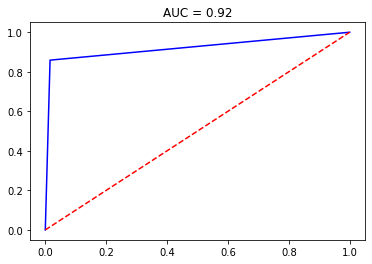

In [1817]:
# Aplicamos la función saca métricas
saca_metricas(y_test, y_pred) # AUC = 0.92, bastante bueno

La presente curva ROC es bastante buena con un AUC igual a 0,92.
En la diagonal principal de la matriz se encuentran la mayor parte de los valores.
El accuracy es del 97,50% bastante buen valor.
La precisión es del 81,45%.
El recall también arroja un buen valor del 0,8588.
Y el f1 es alto ya que la media de precisión y recall es alta, siendo f1 igual a 0,8361.

In [1818]:
X_test.shape

(19094, 18)

In [1819]:
X_train.shape

(76373, 18)

Podemos indicar que nuestro modelo analítico de clasificación con regresión logística es bastante bueno a la luz de las métricas obtenidas. Sin embargo, en el apartado siguiente procederemos a intentar que el mismo sea mejorado.

#### Obtención de probabilidades

Aunque vamos a mejorar nuestro modelo posteriormente, vamos tratar de realizar una predicción de probabilidades con el presente modelo de clasificación de Regresión Logística 'classifier'. 

Para ello primero, trataremos y escalaremos el dataframe de enero 'df_enero' sobre el que queremos predecir los clientes que más probabilidad tienen de irse de la operadora, en tal mes.

In [1820]:
# Ponemos de índice la variable 'id' (que es única por cada registro)
df_enero.set_index('id',inplace=True)

In [1821]:
# Eliminamos las columna 'y' del dataframe de enero
df_enero.drop('y',axis=1,inplace=True)

In [1822]:
df_enero.head()

,edad,facturacion,num_lineas,provincia2,num_dt,incidencia,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal,financiacion,imp_financ,descuentos,conexion,vel_conexion,TV2,meses_antiguedad
id,,,,,,,,,,,,,,,,,,
1,63,216.028109,5,23,0.0,0,95,19,6525,7634,18520,0,0.0,0,0,50,1,14
2,84,255.830842,3,45,0.0,0,44,36,14471,14541,8016,0,0.0,1,0,600,1,29
3,66,135.768153,4,0,0.0,0,94,27,1428,5248,7106,0,0.0,1,1,35,1,217
4,69,255.658527,4,26,0.0,0,186,20,20083,7372,5052,0,0.0,0,0,200,0,53
6,51,99.348645,4,18,0.0,0,37,32,19078,5009,8686,0,0.0,0,0,200,1,266


In [1823]:
# Escalamos las variables de enero
scaler_enero = StandardScaler()
scaled_enero = scaler.fit_transform(df_enero)
scaled_enero = pd.DataFrame(scaled_enero, columns = df_enero.columns)

Utilizamos la función predict_proba para estimar la probabilidad de que un cliente de enero se vaya de la compañía telefónica. 

In [1824]:
modelo_fuga1 = classifier.predict_proba(scaled_enero)[:,1]
modelo_fuga1 = (pd.DataFrame(modelo_fuga1,columns=['probabilidad de Fuga'],index=scaled_enero.index)) # Dataframe
modelo_fuga1.sort_values(by=['probabilidad de Fuga'],ascending=False,axis=0,inplace=True) # Lo ordenamos para ver arriba los más probables

#### Interpretación de los resultados

In [1825]:
modelo_fuga1.head(1000)

,probabilidad de Fuga
53493,1.000000
62101,1.000000
44681,1.000000
20570,1.000000
22547,1.000000
...,...
57115,0.994087
82264,0.994087
33903,0.994082
33109,0.994078


Se ha estimado una probabilidad por cada uno de los clientes de la compañía. Por ejemplo, el cliente 53493 tiene un 100% de probabilidad de irse de la compañía; el cliente 10058 tiene un 99,407% de irse de la compañía.

#### PCA: Análisis de Componente Principales

Vamos a identificar cuáles son las variables que recogen la mayor parte de la varianza de nuestro modelo. 

Este ánálisis es más útil en modelo de clustering.

In [1826]:
pca = PCA(n_components = None)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
explained_variance = pca.explained_variance_ratio_

In [1827]:
### Podemos observar la varianza de las variables 
explained_variance

array([0.10644859, 0.09464762, 0.09115069, 0.05678933, 0.05643257,
       0.05614569, 0.05581425, 0.05568005, 0.05551582, 0.0552678 ,
       0.05511088, 0.05487223, 0.05461961, 0.05449981, 0.05075646,
       0.02075735, 0.02013411, 0.00535711])

Las primera variable explica el 10,64% de la varianza de nuestro modelo, la segunda el 9,46% y así sucesivamente. Las tres últimas explican poco pero todas parecen presentar valores parecidos entre sí de varianza.

### Apartado 5) Mejora del modelo de clasificación

A continación, vamos a tratar de realizar una mejora de nuestro modelo de clasificación construido a través de diversas técnicas tales como feature engineering, análisis de variables, comprobación de overfitting, validación cruzada, tuneo de hiperparámetros a través de automatización, etc.

#### ANÁLISIS DE ELECCIÓN DE VARIABLES DUMMIES FRENTE A NUMÉRICAS

Vamos a tratar de identificar si alguna de las variables categóricas funcionan mejor en nuestro modelo siendo numérica o siendo dummy. Es decir, vamos a pasar a dummies las variables categóricas que así lo permitan y, posteriormente a numéricas, evaluaremos la correlación de todas ellas (quitando al menos una dummy de cada variable para evitar colinealidad) frente a la variable target para identificar cuál funciona mejor como dummy y cuál como numérica. De este modo prodremos intentar mejorar el score del modelo construido.

Para ello tamaremos los dataset originales y haremos un preprocesado para lograr considerar lo descrito. 

In [1828]:
# Cargamos de nuevo todos los datasets, tanto como para diciembre como para enero
df_clientesdic = pd.read_csv('clientes_diciembre.csv', sep='|') # Tabla máster de diciembre
df_consumosdic = pd.read_csv('consumos_diciembre.csv', sep='|') 
df_financiaciondic = pd.read_csv('financiacion_diciembre.csv', sep='|') 
df_productosdic = pd.read_csv('productos_diciembre.csv', sep='|') 

df_clientesene = pd.read_csv('clientes_enero.csv', sep='|')   # Tabla máster de enero
df_consumosene = pd.read_csv('consumos_enero.csv', sep='|') 
df_financiacionene = pd.read_csv('financiacion_enero.csv', sep='|') 
df_productosene = pd.read_csv('productos_enero.csv', sep='|') 

In [1829]:
# Construcción de un único tablón analítico, mergeamos las tablas para diciembre y enero por su key 'id'
dfdic1 = pd.merge(df_clientesdic,df_consumosdic, on='id',how='outer', indicator=False)
dfdic2 = pd.merge(dfdic1,df_financiaciondic, on='id',how='outer', indicator=False)
diciembre = pd.merge(dfdic2,df_productosdic, on='id',how='outer', indicator=False)

dfene1 = pd.merge(df_clientesene,df_consumosene, on='id',how='outer', indicator=False)
dfene2 = pd.merge(dfene1,df_financiacionene, on='id',how='outer', indicator=False)
enero = pd.merge(dfene2,df_productosene, on='id',how='outer', indicator=False)

La variable 'antiguedad' la vamos a transformar realizando lo mismo que hemos hecho anteriormente.
En cuanto a la variable 'provincia' la trataremos posteriormente más adelante. 

In [1830]:
# Transformamos la variable 'antiguedad' a numérica siendo número de meses (este código puede tardar un poco más en ejecutarse)
# Convertimos la fecha de antiguedad a formato fecha
diciembre['antiguedad']= pd.to_datetime(diciembre['antiguedad'])
enero['antiguedad']= pd.to_datetime(enero['antiguedad'])

# Añadimos una variable que identifique la fecha de referencia para ambos dataframes de enero y diciembre
diciembre['cosecha'] = datetime(2019,12,31,0,0)
enero['cosecha'] = datetime(2020,1,31,0,0)

# Calculamos la diferencia en meses entre la fecha de antiguedad y la fecha de cosecha
diciembre['meses_antiguedad']=((diciembre['cosecha'] - diciembre['antiguedad'])/np.timedelta64(1,'M'))
diciembre['meses_antiguedad']=diciembre['meses_antiguedad'].astype(int)

enero['meses_antiguedad']=((enero['cosecha'] - enero['antiguedad'])/np.timedelta64(1,'M'))
enero['meses_antiguedad']=enero['meses_antiguedad'].astype(int)

# Eliminamos la variable 'antiguedad' y 'cosecha' categórica de nuestros datasets
diciembre.drop('antiguedad',axis=1,inplace=True)
enero.drop('antiguedad',axis=1,inplace=True)

diciembre.drop('cosecha',axis=1,inplace=True)
enero.drop('cosecha',axis=1,inplace=True)

In [1831]:
# Ponemos de índice la variable 'id' (que es única por cada registro)
diciembre.set_index('id',inplace=True)
enero.set_index('id',inplace=True)

In [1832]:
# Quitamos valores nulos
diciembre['num_dt'] = diciembre['num_dt'].fillna(value = 0) 
enero['num_dt'] = enero['num_dt'].fillna(value = 0) 

diciembre['imp_financ'] = diciembre['imp_financ'].fillna(value = 0) 
enero['imp_financ'] = enero['imp_financ'].fillna(value = 0) 

In [1833]:
diciembre['incidencia'].value_counts()

SI    5232
Name: incidencia, dtype: int64

In [1834]:
diciembre['incidencia'] = diciembre['incidencia'].fillna(value = 'NO') # Rellenamos vacios a NO
enero['incidencia'] = enero['incidencia'].fillna(value = 'NO')

In [1835]:
diciembre['financiacion'].value_counts()

SI    6372
Name: financiacion, dtype: int64

In [1836]:
diciembre['financiacion'] = diciembre['financiacion'].fillna(value = 'NO') 
enero['financiacion'] = enero['financiacion'].fillna(value = 'NO') 

In [1837]:
diciembre['descuentos'].value_counts()

SI    19154
Name: descuentos, dtype: int64

In [1838]:
diciembre['descuentos'] = diciembre['descuentos'].fillna(value = 'NO')

In [1839]:
diciembre['conexion'].value_counts()

ADSL     47900
FIBRA    47567
Name: conexion, dtype: int64

In [1840]:
diciembre['vel_conexion'].value_counts()

200MB    9677
600MB    9623
50MB     9474
300MB    9461
100MB    9332
20MB     8113
25MB     8112
10MB     7970
30MB     7948
35MB     7947
15MB     7810
Name: vel_conexion, dtype: int64

In [1841]:
# Varibale conexión, eliminamos el 'MB'
diciembre['vel_conexion'] = (diciembre['vel_conexion']
                         .str.extract(r"([\d,\.]+)", expand=False))

enero['vel_conexion'] = (enero['vel_conexion']
                         .str.extract(r"([\d,\.]+)", expand=False))

In [1842]:
diciembre['vel_conexion'].value_counts()

200    9677
600    9623
50     9474
300    9461
100    9332
20     8113
25     8112
10     7970
30     7948
35     7947
15     7810
Name: vel_conexion, dtype: int64

In [1843]:
diciembre['TV'].value_counts()

tv-futbol      47535
tv-familiar    33768
tv-total       14164
Name: TV, dtype: int64

In [1844]:
# Transformamos las variables categóricas a dummies
lista_categoricas=['incidencia','financiacion','descuentos','conexion','vel_conexion','TV']
for k in lista_categoricas:
    dummies = pd.get_dummies(diciembre[k],prefix=k)
    diciembre = pd.concat([diciembre, dummies], axis=1) # Concatenas la variable

In [1845]:
# Dummies para enero
lista_categoricas=['incidencia','financiacion','descuentos','conexion','vel_conexion','TV']
for k in lista_categoricas:
    dummies = pd.get_dummies(enero[k],prefix=k)
    enero = pd.concat([enero, dummies], axis=1) # Concatenas la variable

In [1846]:
diciembre.columns

Index(['edad', 'facturacion', 'provincia', 'num_lineas', 'num_dt',
       'incidencia', 'num_llamad_ent', 'num_llamad_sal', 'mb_datos',
       'seg_llamad_ent', 'seg_llamad_sal', 'financiacion', 'imp_financ',
       'descuentos', 'conexion', 'vel_conexion', 'TV', 'meses_antiguedad',
       'incidencia_NO', 'incidencia_SI', 'financiacion_NO', 'financiacion_SI',
       'descuentos_NO', 'descuentos_SI', 'conexion_ADSL', 'conexion_FIBRA',
       'vel_conexion_10', 'vel_conexion_100', 'vel_conexion_15',
       'vel_conexion_20', 'vel_conexion_200', 'vel_conexion_25',
       'vel_conexion_30', 'vel_conexion_300', 'vel_conexion_35',
       'vel_conexion_50', 'vel_conexion_600', 'TV_tv-familiar', 'TV_tv-futbol',
       'TV_tv-total'],
      dtype='object')

In [1847]:
# También a numéricas
diciembre.incidencia.replace(('NO', 'SI'),
                      (0,1),inplace=True)

diciembre.financiacion.replace(('NO', 'SI'),
                      (0,1),inplace=True)

diciembre.descuentos.replace(('NO', 'SI'),
                      (0,1),inplace=True)

diciembre.conexion.replace(('ADSL', 'FIBRA'),
                      (0,1),inplace=True)

diciembre.vel_conexion.replace(('600', '300', '200', '100', '50', '35', '30', '25', '20', '15', '10'),
                      (1,2,3,4,5,6,7,8,9,10,11),inplace=True)

diciembre.TV.replace(('tv-futbol', 'tv-familiar', 'tv-total'),
                      (1,2,3),inplace=True)

In [1848]:
# También a numéricas para enero
enero.incidencia.replace(('NO', 'SI'),
                      (0,1),inplace=True)

enero.financiacion.replace(('NO', 'SI'),
                      (0,1),inplace=True)

enero.descuentos.replace(('NO', 'SI'),
                      (0,1),inplace=True)

enero.conexion.replace(('ADSL', 'FIBRA'),
                      (0,1),inplace=True)

enero.vel_conexion.replace(('600', '300', '200', '100', '50', '35', '30', '25', '20', '15', '10'),
                      (1,2,3,4,5,6,7,8,9,10,11),inplace=True)

enero.TV.replace(('tv-futbol', 'tv-familiar', 'tv-total'),
                      (1,2,3),inplace=True)

In [1849]:
diciembre_y.head()

id
1    0
2    0
3    0
4    0
5    1
Name: y, dtype: int64

In [1850]:
diciembre_y.to_frame()

,y
id,
1,0
2,0
3,0
4,0
5,1
...,...
99995,0
99996,0
99997,0


In [1851]:
# Insertamos la variable target a nuestro dataset de diciembre
diciembre = pd.merge(diciembre,diciembre_y, on='id',how='outer', indicator=False)
df_diciembre = pd.merge(df_diciembre,diciembre_y, on='id',how='outer', indicator=False)

In [1852]:
diciembre.head()

,edad,facturacion,provincia,num_lineas,num_dt,incidencia,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,...,vel_conexion_25,vel_conexion_30,vel_conexion_300,vel_conexion_35,vel_conexion_50,vel_conexion_600,TV_tv-familiar,TV_tv-futbol,TV_tv-total,y
id,,,,,,,,,,,,,,,,,,,,,
1,63,216.028109,La Rioja,5,0.0,0,110,79,10897,12806,...,0,0,0,0,1,0,0,1,0,0
2,84,255.830842,Vizcaya,3,0.0,0,189,89,18657,6499,...,0,0,0,0,0,1,0,1,0,0
3,66,135.768153,Albacete,4,0.0,0,129,30,15511,17013,...,0,0,0,1,0,0,0,1,0,0
4,69,255.658527,Lugo,4,0.0,0,51,52,12670,3393,...,0,0,0,0,0,0,1,0,0,0
5,25,22.302845,Tarragona,2,2.0,0,183,3,23756,18436,...,0,0,0,0,0,0,0,1,0,1


In [1853]:
diciembre.columns

Index(['edad', 'facturacion', 'provincia', 'num_lineas', 'num_dt',
       'incidencia', 'num_llamad_ent', 'num_llamad_sal', 'mb_datos',
       'seg_llamad_ent', 'seg_llamad_sal', 'financiacion', 'imp_financ',
       'descuentos', 'conexion', 'vel_conexion', 'TV', 'meses_antiguedad',
       'incidencia_NO', 'incidencia_SI', 'financiacion_NO', 'financiacion_SI',
       'descuentos_NO', 'descuentos_SI', 'conexion_ADSL', 'conexion_FIBRA',
       'vel_conexion_10', 'vel_conexion_100', 'vel_conexion_15',
       'vel_conexion_20', 'vel_conexion_200', 'vel_conexion_25',
       'vel_conexion_30', 'vel_conexion_300', 'vel_conexion_35',
       'vel_conexion_50', 'vel_conexion_600', 'TV_tv-familiar', 'TV_tv-futbol',
       'TV_tv-total', 'y'],
      dtype='object')

In [1854]:
diciembre.dtypes

edad                  int64
facturacion         float64
provincia            object
num_lineas            int64
num_dt              float64
incidencia            int64
num_llamad_ent        int64
num_llamad_sal        int64
mb_datos              int64
seg_llamad_ent        int64
seg_llamad_sal        int64
financiacion          int64
imp_financ          float64
descuentos            int64
conexion              int64
vel_conexion          int64
TV                    int64
meses_antiguedad      int32
incidencia_NO         uint8
incidencia_SI         uint8
financiacion_NO       uint8
financiacion_SI       uint8
descuentos_NO         uint8
descuentos_SI         uint8
conexion_ADSL         uint8
conexion_FIBRA        uint8
vel_conexion_10       uint8
vel_conexion_100      uint8
vel_conexion_15       uint8
vel_conexion_20       uint8
vel_conexion_200      uint8
vel_conexion_25       uint8
vel_conexion_30       uint8
vel_conexion_300      uint8
vel_conexion_35       uint8
vel_conexion_50     

In [1855]:
# Observamos que variables tienen más correlación con al variable target 'y'
corr = abs(diciembre.corr())
corr[['y']].sort_values(by = 'y',ascending = False).style.background_gradient()

,y
y,1.000000
num_dt,0.504867
incidencia,0.500885
incidencia_SI,0.500885
incidencia_NO,0.500885
descuentos_SI,0.141447
descuentos_NO,0.141447
descuentos,0.141447
financiacion,0.074597
financiacion_NO,0.074597


A la luz de la presente tabla de correlaciones por variables, consideramos que sólo la variable 'descuentos' funciona mejor como dummy, el resto funcionan mejor como numéricas. 

In [1856]:
df_diciembre.head()

,edad,facturacion,num_lineas,provincia2,num_dt,incidencia,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal,financiacion,imp_financ,descuentos,conexion,vel_conexion,TV2,meses_antiguedad,y
id,,,,,,,,,,,,,,,,,,,
1,63,216.028109,5,23,0.0,0,110,79,10897,12806,13751,0,0.0,0,0,50,1,13,0
2,84,255.830842,3,45,0.0,0,189,89,18657,6499,10862,0,0.0,1,0,600,1,28,0
3,66,135.768153,4,0,0.0,0,129,30,15511,17013,16743,0,0.0,1,1,35,1,216,0
4,69,255.658527,4,26,0.0,0,51,52,12670,3393,6771,0,0.0,0,0,200,0,52,0
5,25,22.302845,2,40,2.0,0,183,3,23756,18436,4485,0,0.0,0,1,10,1,268,1


In [1857]:
descuentos_dummy = diciembre['descuentos_SI'] # Seleccionamos sólo una de las dummies de 'descuentos' para evitar colinealidad

In [1858]:
df_diciembre = pd.merge(df_diciembre, descuentos_dummy, on='id',how='outer', indicator=False)

In [1859]:
df_diciembre.drop('descuentos',axis=1,inplace=True) # Eliminamos la variable 'descuentos' original de nuestro set de datos

In [1860]:
df_diciembre.dtypes

edad                  int64
facturacion         float64
num_lineas            int64
provincia2            int32
num_dt              float64
incidencia            int64
num_llamad_ent        int64
num_llamad_sal        int64
mb_datos              int64
seg_llamad_ent        int64
seg_llamad_sal        int64
financiacion          int64
imp_financ          float64
conexion              int64
vel_conexion          int32
TV2                   int32
meses_antiguedad      int32
y                     int64
descuentos_SI         uint8
dtype: object

In [1861]:
# 'vel_conexion' funciona mejor en cuanto a correlación transformandola de este modo
df_diciembre.vel_conexion.replace((600, 300, 200, 100, 50, 35, 30, 25, 20, 15, 10),
                      (1,2,3,4,5,6,7,8,9,10,11),inplace=True)

In [1862]:
df_diciembre.head()

,edad,facturacion,num_lineas,provincia2,num_dt,incidencia,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal,financiacion,imp_financ,conexion,vel_conexion,TV2,meses_antiguedad,y,descuentos_SI
id,,,,,,,,,,,,,,,,,,,
1,63,216.028109,5,23,0.0,0,110,79,10897,12806,13751,0,0.0,0,5,1,13,0,0
2,84,255.830842,3,45,0.0,0,189,89,18657,6499,10862,0,0.0,0,1,1,28,0,1
3,66,135.768153,4,0,0.0,0,129,30,15511,17013,16743,0,0.0,1,6,1,216,0,1
4,69,255.658527,4,26,0.0,0,51,52,12670,3393,6771,0,0.0,0,3,0,52,0,0
5,25,22.302845,2,40,2.0,0,183,3,23756,18436,4485,0,0.0,1,11,1,268,1,0


#### FEATURE ENGINEERING: Trameo de variables

Vamos a ver si alguna de las variables podría funcionar mejor trameada.

In [1863]:
# Definimos la función requerida
def proporciones_final (var,target,df):

    proporcion = pd.DataFrame()
    
    proporcion['%depositos'] = df[target].groupby(df[var]).mean()*100
    proporcion['Conteo'] = df[target].groupby(df[var]).count()
    proporcion= proporcion.round(3)   
    proporcion_filtered = proporcion[(proporcion['%depositos']>0) & (proporcion['Conteo']>10)]
        
    if len(proporcion_filtered)<100 and len(proporcion_filtered)>1:
        fig = plt.figure()
        ax = proporcion_filtered['Conteo'].plot(kind='bar',grid=True)
                
        ax2 = ax.twinx()
        ax2.plot(proporcion_filtered['%depositos'].values, linestyle='-', linewidth=2.0,color='g')
        plt.tight_layout()   

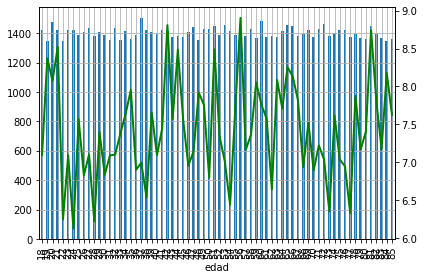

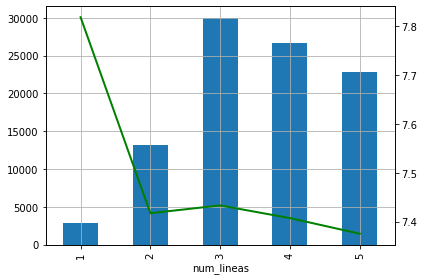

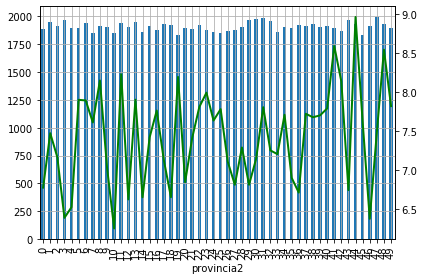

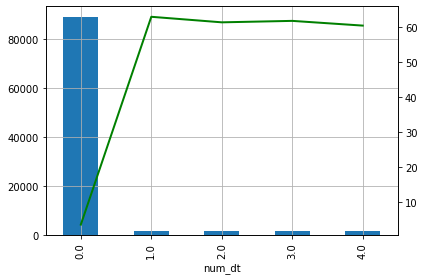

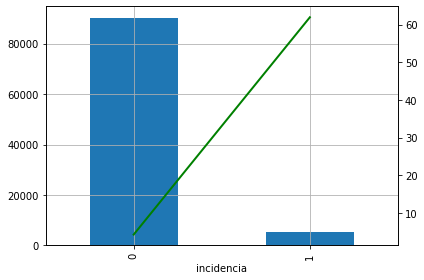

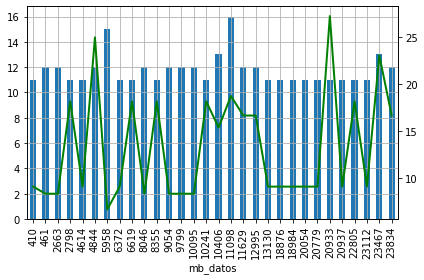

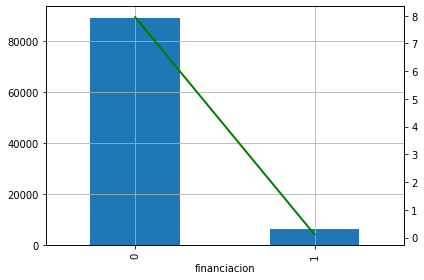

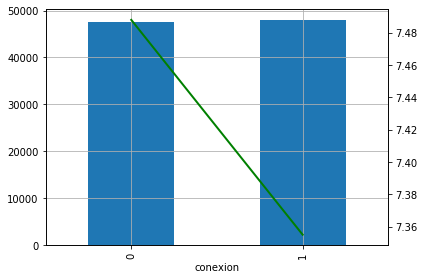

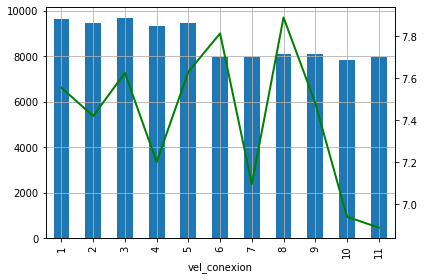

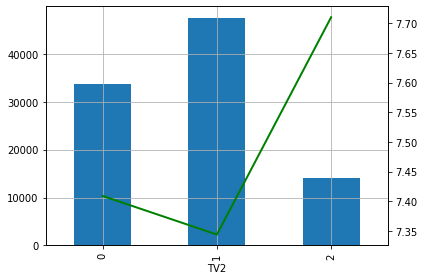

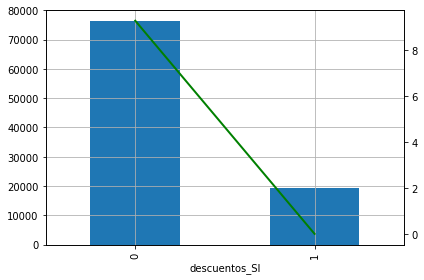

In [1864]:
for i in df_diciembre.columns:
    proporciones_final (i, 'y', df_diciembre)

'num_lineas' podría ser tramea, los clientes que tiene sólo una línea son más propensos a poder irse.

En 'num_dt' (número de líneas en impago) si el ciente tiene 1 o más líneas en impago es más propenso a irse. Podría ser trameada.

'TV2' puede ser trameada, ya que los cliente que tienen 'tv-total' pueden ser más propensos a irse.

In [1865]:
# Hacemos las transformaciones, trameamos tales variables con la función Lambda
df_diciembre['num_lineas_nueva'] = df_diciembre['num_lineas'].apply(lambda x: 0 if x<=1 else 1)
df_diciembre['num_dt_nueva'] = df_diciembre['num_dt'].apply(lambda x: 0 if x<1 else 1)
df_diciembre['TV2_nueva'] = df_diciembre['TV2'].apply(lambda x: 0 if x<=1 else 1)

In [1866]:
df_diciembre['TV2_nueva'].value_counts()

0    81303
1    14164
Name: TV2_nueva, dtype: int64

In [1867]:
# Trameamos la edad para ver si funciona mejor
df_diciembre['edad_nueva'] = df_diciembre['edad'].apply(lambda x: 0 if x<=35 else (1 if x>35 and x<60 else(2))) 

In [1868]:
df_diciembre['edad_nueva'].value_counts()

2    36464
1    33822
0    25181
Name: edad_nueva, dtype: int64

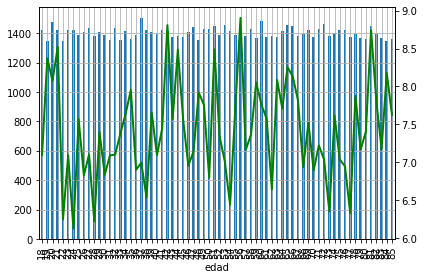

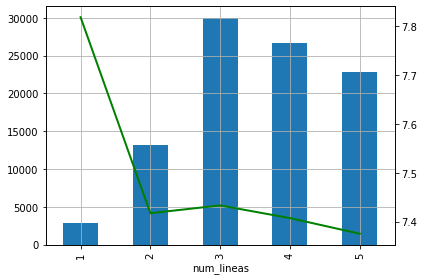

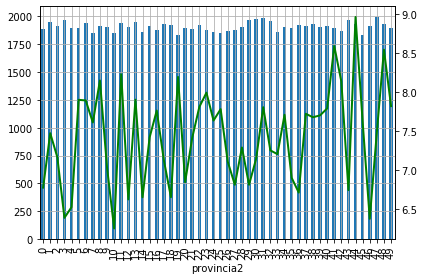

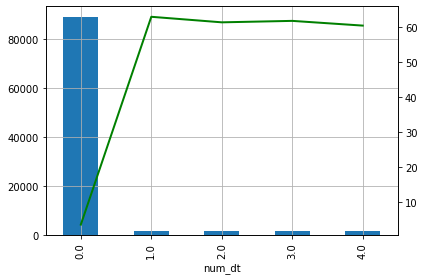

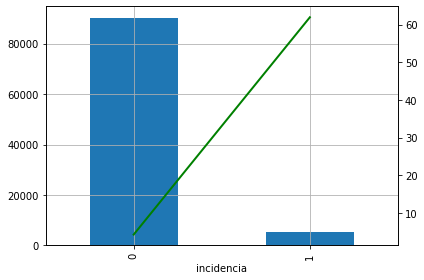

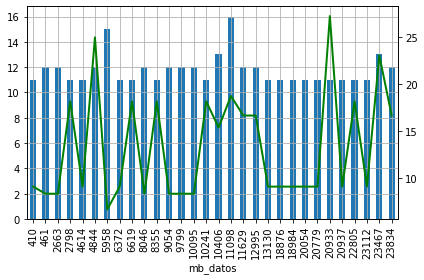

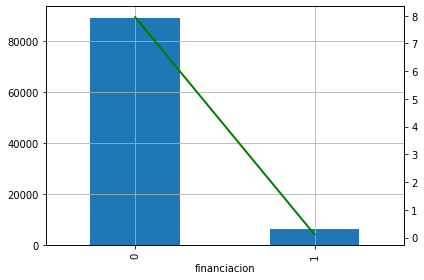

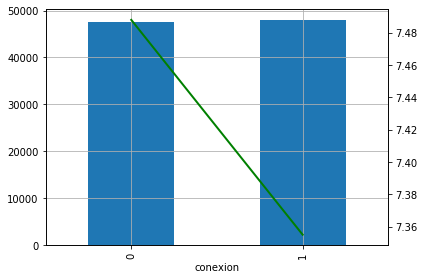

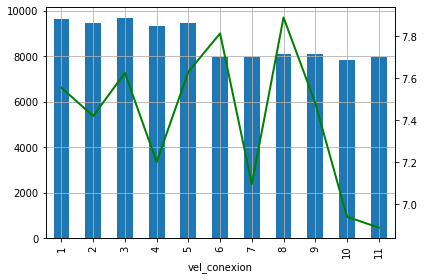

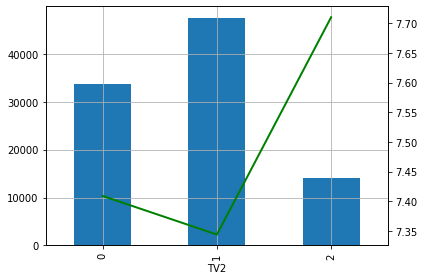

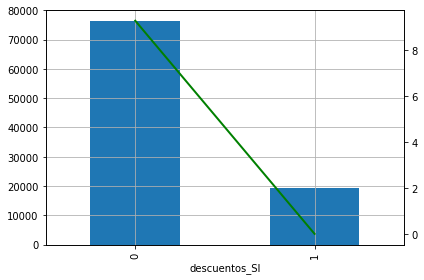

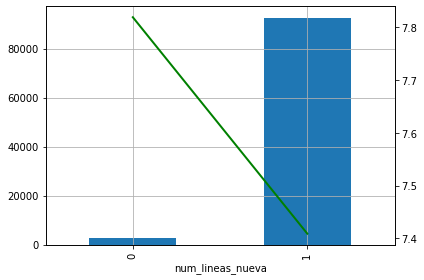

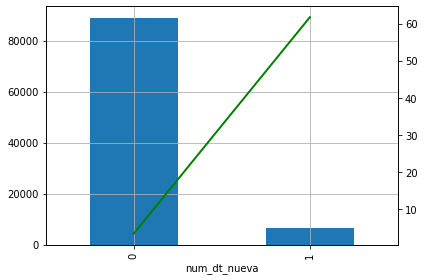

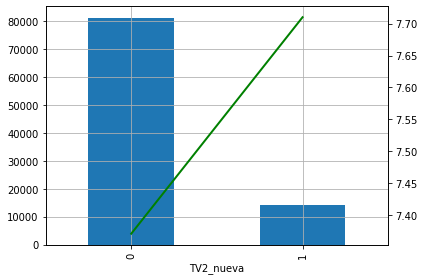

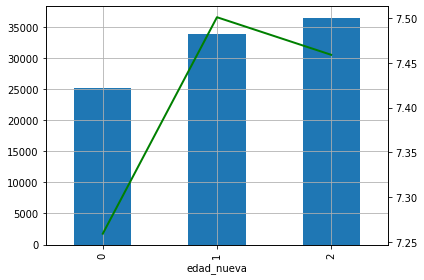

In [1869]:
# Graficamos de nuevo
for i in df_diciembre.columns:
    proporciones_final (i, 'y', df_diciembre)

In [1870]:
# Observamos que variables tienen más correlación con al variable target 'y'
corr = abs(df_diciembre.corr())
corr[['y']].sort_values(by = 'y',ascending = False).style.background_gradient()

,y
y,1.000000
num_dt_nueva,0.560509
num_dt,0.504867
incidencia,0.500885
descuentos_SI,0.141447
financiacion,0.074597
imp_financ,0.067626
provincia2,0.006305
num_llamad_ent,0.006130
vel_conexion,0.005046


'num_dt_nueva' funciona mejor que 'num_dt' original.

'TV2_nueva' funciona mejor que 'TV2' anterior.

'num_lineas-nueva' funciona mejor que 'num_lineas' original.

Y 'edad' original funciona mejor que 'edad_nueva1.

In [1871]:
# Eliminamos de nuestro dataframe las variables no necesarias.
df_diciembre.drop('num_dt',axis=1,inplace=True)
df_diciembre.drop('TV2',axis=1,inplace=True)
df_diciembre.drop('num_lineas',axis=1,inplace=True)
df_diciembre.drop('edad_nueva', axis=1, inplace=True)

In [1872]:
df_diciembre.dtypes

edad                  int64
facturacion         float64
provincia2            int32
incidencia            int64
num_llamad_ent        int64
num_llamad_sal        int64
mb_datos              int64
seg_llamad_ent        int64
seg_llamad_sal        int64
financiacion          int64
imp_financ          float64
conexion              int64
vel_conexion          int64
meses_antiguedad      int32
y                     int64
descuentos_SI         uint8
num_lineas_nueva      int64
num_dt_nueva          int64
TV2_nueva             int64
dtype: object

#### Obtención del valor del VIF

Vamos a calcular el valor del VIF para todas las variables menos la objetivo. Para esto se realiza una regresión lineal de cada una de las variables frente al resto y aplicamos la fórmula del VIF
$$
    VIF_i = \frac{1}{1 - R_i^2}
$$

In [1873]:
# Borrado de la variable objetivo
df_diciembre_vif = df_diciembre.copy(deep = True)
features = list(df_diciembre_vif.columns)
features.remove('y')
df_diciembre_vif = df_diciembre_vif[features]

for i in range(len(features)):
    var = features[i]
    fet = features[:]
    fet.remove(var)
    
    x = df_diciembre_vif[fet]
    y = df_diciembre[var]
    
    model = LinearRegression()
    model.fit(x, y)
    
    vif = 1 / (1 - model.score(x, y)) # VIF
    
    print ('El valor del VIF para la variable', var, 'es:', vif)

El valor del VIF para la variable edad es: 1.000328352389576
El valor del VIF para la variable facturacion es: 1.3757293908591572
El valor del VIF para la variable provincia2 es: 1.0002204182090395
El valor del VIF para la variable incidencia es: 1.0001998497828075
El valor del VIF para la variable num_llamad_ent es: 1.0002555723150797
El valor del VIF para la variable num_llamad_sal es: 1.0000781504650023
El valor del VIF para la variable mb_datos es: 1.0001468990352143
El valor del VIF para la variable seg_llamad_ent es: 1.0002564547063615
El valor del VIF para la variable seg_llamad_sal es: 1.0001931358600318
El valor del VIF para la variable financiacion es: 5.47013393231134
El valor del VIF para la variable imp_financ es: 5.470947379851529
El valor del VIF para la variable conexion es: 4.09043246393248
El valor del VIF para la variable vel_conexion es: 4.090616396117868
El valor del VIF para la variable meses_antiguedad es: 1.0001359821593219
El valor del VIF para la variable desc

Las variables 'imp_financ' y 'financiacion' presentan un VIF por encima de 5. Eliminamos 'imp_financ' y volvemos a ejecutar el VIF.

In [1874]:
df_diciembre_vif = df_diciembre.copy(deep = True)
features = list(df_diciembre_vif.columns)
features.remove('imp_financ')
df_diciembre_vif = df_diciembre_vif[features]

for i in range(len(features)):
    var = features[i]
    fet = features[:]
    fet.remove(var)
    
    x = df_diciembre_vif[fet]
    y = df_diciembre[var]
    
    model = LinearRegression()
    model.fit(x, y)
    
    vif = 1 / (1 - model.score(x, y)) # VIF
    
    print ('El valor del VIF para la variable', var, 'es:', vif)

El valor del VIF para la variable edad es: 1.0003226715115239
El valor del VIF para la variable facturacion es: 1.3756210363457826
El valor del VIF para la variable provincia2 es: 1.0002389387910957
El valor del VIF para la variable incidencia es: 1.615271120605697
El valor del VIF para la variable num_llamad_ent es: 1.00022254321113
El valor del VIF para la variable num_llamad_sal es: 1.0000847740896912
El valor del VIF para la variable mb_datos es: 1.0001475537964764
El valor del VIF para la variable seg_llamad_ent es: 1.0002288600194376
El valor del VIF para la variable seg_llamad_sal es: 1.0001918223705104
El valor del VIF para la variable financiacion es: 1.0130712502008328
El valor del VIF para la variable conexion es: 4.090431352781861
El valor del VIF para la variable vel_conexion es: 4.090569899190661
El valor del VIF para la variable meses_antiguedad es: 1.0001428327640467
El valor del VIF para la variable y es: 2.4435891398542107
El valor del VIF para la variable descuentos_

Una vez eliminada la variable que presenta el VIF más alto el valor de este para resto de las variables cambia. Ahora podemos ver que ninguna de las variable restantes tiene un valor del VIF superior a cinco. Por lo que se ha eliminado las variables colineales de nuestro conjunto de datos.

In [1875]:
df_diciembre.drop('imp_financ',axis=1,inplace=True)

In [1876]:
lista_var= list(df_diciembre.columns)
lista_var

['edad',
 'facturacion',
 'provincia2',
 'incidencia',
 'num_llamad_ent',
 'num_llamad_sal',
 'mb_datos',
 'seg_llamad_ent',
 'seg_llamad_sal',
 'financiacion',
 'conexion',
 'vel_conexion',
 'meses_antiguedad',
 'y',
 'descuentos_SI',
 'num_lineas_nueva',
 'num_dt_nueva',
 'TV2_nueva']

#### Detección de outliers o valores fuerta de rango

Vamos a graficar los histogramas de las variables que presenten outliers o valores fuera de rango, lo vamos a hacer una a una ya que tarda bastante en ejecutarse el código si lo hacemos con todas a la vez.

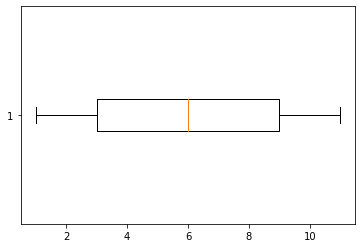

In [1877]:
# Pintamos los histogramas de cada variable, lo hacemos una a una porque hacerlo a la vez tarda en ejercutar mucho
plt.boxplot(df_diciembre['vel_conexion'], vert= False) # Gráficos en horizontal
plt.show()

No encontramos valores outliers en ninguna de nuestras variables. 

#### Selección de variables: Análisis Univariante

Vamos a tratar de seleccionar las variables que mejor explican nuestro modelo escogiendo el método de selección de variables de "análisis multivariante".

In [1878]:
target = 'y'
features = list(df_diciembre.columns)
features.remove('y')

x = df_diciembre[features]
y = df_diciembre[target]

Vamos a ver cuáles son las 5 mejores variables que explican mejor nuestro modelo (aunque podríamos escoger incluso menos, también más). Pero vamos a verlo sólo sobre estas cinco.

In [1879]:
S_chi5 = SelectKBest(chi2, k = 5) # LLamo al modelo y le digo k (el número de variables con las que te quieres quedar)
X_chi5 = S_chi5.fit_transform(x, y)

print ("Listado de variables ", np.asarray(list(x))[S_chi5.get_support()])

Listado de variables  ['incidencia' 'mb_datos' 'financiacion' 'descuentos_SI' 'num_dt_nueva']


Las cinco variables que mejor explican nuestro modelo son 'incidencia', 'mb_datos', 'imp_financ', 'descuentos_SI' y 'num_dt_nueva'. Estas son las cinco variables con más importancia. En todo caso, vamos a continuar nuestro análisis, veremos por ejemplo más adelante que 'imp_financ' deberá ser eliminada por presentar problema de colinealidad (según VIF).

#### RandomForest

Vamos a probar a realizar un modelo de clasificación Random Forest

In [1880]:
df_diciembre.drop('y',axis=1,inplace=True)

In [1881]:
X_train, X_test, y_train, y_test = train_test_split(df_diciembre, diciembre_y, test_size=0.2, random_state=42)

In [1882]:
model1 = RandomForestClassifier(n_estimators=100, random_state=0).fit(X_train, y_train)
model1

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [1883]:
# Validación cruzada (cv=5, para obtener 5 resultados)
results = cross_val_score(estimator=model1, X=X_train, y=y_train, cv=5)
results

array([0.98291326, 0.98487725, 0.98382979, 0.98409061, 0.98245384])

Los valores de esta array de resultados son muy parecidos, por tanto el modelo es muy estable y no hay overfitting.

In [1884]:
print(results.mean())

0.9836329498455598


In [1885]:
print(results.std())

0.000860782613000239


La varianza es bajísima. Esto no nos gusta. 

matriz de confusión
[[17353   295]
 [   11  1435]]
accuracy
0.983974023253378
precision
0.8294797687861272
recall
0.9923928077455049
f1
0.9036523929471032
AUC
0.9878385162934233


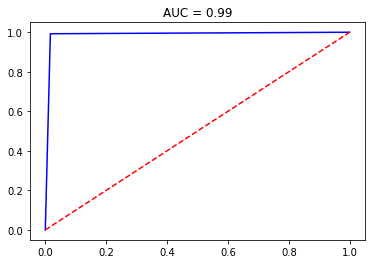

In [1886]:
y_pred = model1.predict(X_test)
saca_metricas(y_test, y_pred) # AUC = 0.99

Nuestras métricas han mejorado mucho en este modelo 'model1' con RandomForest. Con un AUC del 0,99.

El accuracy en el presente es de un 98,39% frente al accuracy del modelo de Regresión Logítica primero, 'classifier', que era del 97,50%.

#### Grid-search sobre RandomForest

Grid-Search es usado para encontrar los hiperparámetros óptimos del un modelo (en este caso lo hemos aplicado sobre model1) y nos ofrezca resultados con una mayor precisión

In [1887]:
grid_param = {
    'n_estimators': [100, 300, 500, 800, 1000],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False]
}

In [1888]:
# Automatización de parámetros
model_grid =GridSearchCV(estimator=model1,
                     param_grid=grid_param,
                     scoring='accuracy', # que los parámetros sean óptimos para la métrica accuracy
                     cv=5, # Validación cruzada
                     n_jobs=-1)

In [1889]:
model_grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=0,
                                   

In [1890]:
print(model_grid.best_params_)

{'bootstrap': True, 'criterion': 'gini', 'n_estimators': 300}


In [1891]:
print(model_grid.best_score_)

0.9836722305718542


matriz de confusión
[[17352   296]
 [   10  1436]]
accuracy
0.983974023253378
precision
0.8290993071593533
recall
0.9930843706777317
f1
0.9037130270610446
AUC
0.988155965937234


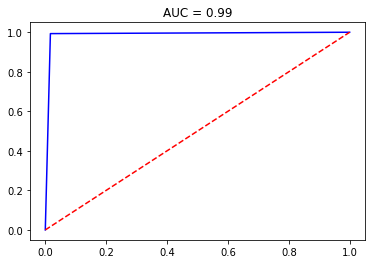

In [1892]:
y_pred = model_grid.predict(X_test)
saca_metricas(y_test, y_pred) # AUC = 0.99

Presenta grid-search sobre el RandomForest anterior presenta idénticas métricas.

#### Xgboost

In [1893]:
X_train, X_test, y_train, y_test = train_test_split( df_diciembre,
                                                    diciembre_y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify = diciembre_y)

In [1894]:
model_xgboost = XGBClassifier(base_score=0.7, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=2, # máxima profundida de los árboles 2
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [1895]:
model_xgboost.fit(X_train, y_train)

XGBClassifier(base_score=0.7, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=-1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0,
              silent=True, subsample=1, verbosity=1)

In [1896]:
y_pred = model_xgboost.predict(X_test)

matriz de confusión
[[17367   310]
 [    8  1409]]
accuracy
0.9833455535770399
precision
0.8196625945317044
recall
0.9943542695836274
f1
0.8985969387755102
AUC
0.9884086786058093


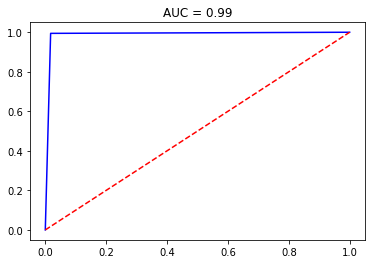

In [1897]:
saca_metricas(y_test, y_pred) # AUC = 0.99

Con el modelo xgboost obtenemos unas métricas muy parecidas al modelo RandomForest 'model1' pero no mejores. El preferido entre los dos es el RandomForest 'model1'.

#### Regresión Logística sin escalado de variables

In [1898]:
X_train, X_test, y_train, y_test = train_test_split(df_diciembre,
                                                    diciembre_y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify = diciembre_y)

In [1899]:
# Generamos la regresión logística y creamos la variable y_pred
Reg_log2 = LogisticRegression(max_iter=1000).fit(X_train, y_train)

C:\Users\maria\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


El warning es debido, lo más probable, a un problema de versionado de Python, Sklearn. Como comprobaremos en la regresión poterior, éste desaparece al escalar.

matriz de confusión
[[17367   310]
 [    8  1409]]
accuracy
0.9833455535770399
precision
0.8196625945317044
recall
0.9943542695836274
f1
0.8985969387755102
AUC
0.9884086786058093


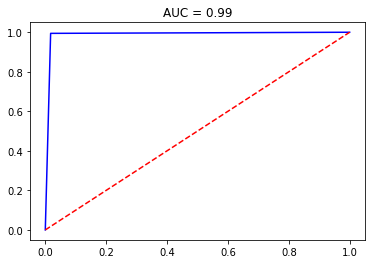

In [1900]:
# Aplicamos la función saca métricas para ver antes que resultados ofrece
saca_metricas(y_test, y_pred) # AUC = 0.99, bastante bueno tras la mejora de variables

In [1901]:
y_pred = Reg_log2.predict(X_test)

El mensaje de warning que se genera al correr el código anterior probablemente es un problema de versionado de Python, Sklearn.

Como podemos comprobar, si no escalamos las variables entonces el modelo no funciona. El modelo no es capaz de generar una matriz de confusión óptima; por ejemplo, en este caso, vemos que sólo es capaz de distinguir sólo un valo como verdedero positivo.

#### Regresión Logística con escalado de variables

In [1902]:
# Escalamos
scaler = StandardScaler()
scaled_X = scaler.fit_transform(df_diciembre)
scaled_X = pd.DataFrame(scaled_X, columns = df_diciembre.columns)

In [1903]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X,
                                                    diciembre_y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify = diciembre_y)

In [1904]:
# Generamos la regresión logística y creamos la variable y_pred
Reg_log = LogisticRegression(max_iter=1000).fit(X_train, y_train)

In [1905]:
# Validación cruzada (cv=5, para obtener 5 resultados)
results = cross_val_score(estimator=Reg_log, X=X_train, y=y_train, cv=5)
results # Valores parecidos, no hay overfitting, modelo estable

array([0.98513912, 0.98310966, 0.98533552, 0.98238837, 0.9827812 ])

In [1906]:
y_pred = Reg_log.predict(X_test)

matriz de confusión
[[17364   313]
 [    8  1409]]
accuracy
0.9831884361579554
precision
0.8182346109175378
recall
0.9943542695836274
f1
0.8977381331634279
AUC
0.9883238225782028


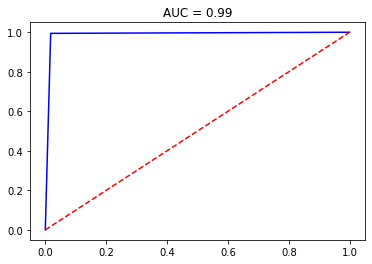

In [1907]:
# Aplicamos la función saca métricas para ver antes que resultados ofrece
saca_metricas(y_test, y_pred) # AUC = 0.99, bastante bueno tras la mejora de variables

Tras la mejora de variables, nuestras métricas con la Regresión Logística han mejorado considerablemente. 

In [1908]:
# Intercepto y coeficientes del modelo
Reg_log.intercept_

array([-8.38867113])

In [1909]:
Reg_log.coef_

array([[ 1.86356984e-02,  5.60574247e-02, -2.83373809e-02,
         1.78959277e+00,  9.20702991e-03,  4.87200576e-05,
         4.37476304e-02,  1.58246578e-02, -4.00253535e-03,
        -2.25513497e+00, -2.23227132e-02, -3.82105928e-03,
        -4.32857681e-03, -4.70427438e+00,  1.78470859e-02,
         1.97404578e+00,  2.37254299e-03]])

In [1910]:
# Odd-ratio: es la exponencial de los coeficientes del modelo de regresión
np.exp(Reg_log.coef_)

array([[1.01881043, 1.05765842, 0.97206036, 5.98701389, 1.00924954,
        1.00004872, 1.04471867, 1.01595053, 0.99600546, 0.10485939,
        0.97792459, 0.99618623, 0.99568078, 0.00905648, 1.0180073 ,
        7.19974626, 1.00237536]])

#### TRATADO DEL DATASET DE ENERO 

In [1911]:
df_enero.tail()

,edad,facturacion,num_lineas,provincia2,num_dt,incidencia,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal,financiacion,imp_financ,descuentos,conexion,vel_conexion,TV2,meses_antiguedad
id,,,,,,,,,,,,,,,,,,
99996,36,215.890326,3,16,0.0,0,217,96,9059,7735,8823,0,0.000000,0,1,30,1,81
99997,68,285.890750,5,3,0.0,0,168,99,9303,4798,3996,1,14.616422,0,0,200,1,197
99998,20,383.167610,4,48,0.0,0,188,71,19018,1237,16720,0,0.000000,0,1,20,1,82
99999,53,53.301395,2,38,0.0,0,138,40,20264,10552,17637,0,0.000000,0,0,50,1,0
100000,18,57.158927,4,24,0.0,0,217,65,21772,14141,927,0,0.000000,1,1,25,0,123


In [1912]:
descuentos_dummy = enero['descuentos_SI'] # Seleccionamos sólo una de las dummies de 'descuentos' para evitar colinealidad
df_enero = pd.merge(df_enero, descuentos_dummy, on='id',how='outer', indicator=False)
df_enero.drop('descuentos',axis=1,inplace=True) # Eliminamos la variable 'descuentos' original de nuestro set de datos

In [1913]:
# 'vel_conexion' funciona mejor en cuanto a correlación transformandola de este modo
df_enero.vel_conexion.replace((600, 300, 200, 100, 50, 35, 30, 25, 20, 15, 10),
                      (1,2,3,4,5,6,7,8,9,10,11),inplace=True)

In [1914]:
# Hacemos las transformaciones, trameamos tales variables con la función Lambda
df_enero['num_lineas_nueva'] = df_enero['num_lineas'].apply(lambda x: 0 if x<=1 else 1)
df_enero['num_dt_nueva'] = df_enero['num_dt'].apply(lambda x: 0 if x<1 else 1)
df_enero['TV2_nueva'] = df_enero['TV2'].apply(lambda x: 0 if x<=1 else 1)

In [1915]:
# Eliminamos de nuestro dataframe las variables no necesarias.
df_enero.drop('num_dt',axis=1,inplace=True)
df_enero.drop('TV2',axis=1,inplace=True)
df_enero.drop('num_lineas',axis=1,inplace=True)

In [1916]:
# Eliminamos 'imp_financ' por tener un VIF mayor a 5 (problema de colinealidad)
df_enero.drop('imp_financ',axis=1,inplace=True)

#### Escalado de los datos de enero

Para que realmente el escalado del dataset de enero sea eficiente, hay que transformar los datos de enero con el escalador ajustado.

En este caso, esta línea de código no sería válida: scaled_enero = scaler.fit_transform(df_enero)

Debemos escalar los datos de diciembre y una vez hecho esto, escalar los de enero sin el 'fit', del siguiente modo:

scaled_enero = scaler.transform(df_enero)

Ya que de no hacerlo así podría generar problemas el escalado para el dataset de enero. 

Al realizarlo de este modo, nos hemos percatado que en la obtención de las tablas de 'probabilidad de Fuga' los datos son mucho más ajustados o precisos. Por ejemplo, en el caso del modelo 'Reg_log' si no realizamos el escalado de este modo, nos ofrece probabilidades de fuga de algunos clientes del 100%, hecho que nos ha resultado del todo llamativo; sin embargo, escalando el dataset de enero de este modo, se nos ofrece que los clientes con mayores probabilidades de fuga son del 99,99%. Parece que ajusta mejor y es más correcto.

In [1917]:
# Escalamos las variables de enero
scaler = StandardScaler()

scaled_X = scaler.fit_transform(df_diciembre)
scaled_X = pd.DataFrame(scaled_X, columns = df_diciembre.columns)

scaled_enero = scaler.transform(df_enero)
scaled_enero = pd.DataFrame(scaled_enero, columns = df_enero.columns)

### Apartado 6) Predicción

#### Obtención de probabilidades

Con el mejor de nuestro modelos 'model1' RandomForest vamos a predecir los clientes que más probabilidad tienen de irse de la operadora en el mes de enero.

Utilizamos la función predict_proba para estimar la probabilidad de que un cliente de enero se vaya de la compañía telefónica.

In [1918]:
modelo_fuga2 = model1.predict_proba(scaled_enero)[:,1]
modelo_fuga2 = (pd.DataFrame(modelo_fuga2,columns=['probabilidad de Fuga'],index=scaled_enero.index)) # Dataframe
modelo_fuga2.sort_values(by=['probabilidad de Fuga'],ascending=False,axis=0,inplace=True) # Lo ordenamos para ver arriba los más probables

#### Interpretación de los Resultados

In [1919]:
modelo_fuga2.head(1000)

,probabilidad de Fuga
4688,0.66
29326,0.65
25538,0.65
9628,0.65
83196,0.65
...,...
62941,0.46
51284,0.46
26312,0.46
63211,0.46


Estima una probabilidad por cada uno de los clientes de la compañía telefónica. Por ejemplo, el cliente 4688 tiene un 66% de probabilidad de irse de la compañía. 

Predecimos con el modelo de Regresión Logística tras el mejorado y tratamiento de las variables, con el modelo 'Reg_log'.

In [1920]:
modelo_fuga3 = Reg_log.predict_proba(scaled_enero)[:,1]
modelo_fuga3 = (pd.DataFrame(modelo_fuga3,columns=['probabilidad de Fuga'],index=scaled_enero.index)) # Dataframe
modelo_fuga3.sort_values(by=['probabilidad de Fuga'],ascending=False,axis=0,inplace=True) # Lo ordenamos para ver arriba los más probables

In [1921]:
modelo_fuga3.head(1000)

,probabilidad de Fuga
33406,0.999920
44681,0.999919
69620,0.999916
27402,0.999916
47968,0.999916
...,...
48854,0.804818
69803,0.804750
14639,0.804703
27015,0.804695


En este caso el modelo 'Reg_log' parece ofrecer mayor probabilidad en su predicción. Por ejemplo, en este caso el cliente 33406 tiene un 99,99% de probabilidad de irse de la compañía. 

Por tanto, habría que intentar retener en la compañía a los primeros cliente de la presente tabla de probabilidades.

A continuación, predecimos probabilidades sobre el xgboost.

In [1922]:
modelo_fuga4 = model_xgboost.predict_proba(scaled_enero)[:,1]
modelo_fuga4 = (pd.DataFrame(modelo_fuga4,columns=['probabilidad de Fuga'],index=scaled_enero.index)) # Dataframe
modelo_fuga4.sort_values(by=['probabilidad de Fuga'],ascending=False,axis=0,inplace=True) # Lo ordenamos para ver arriba los más probables

In [1923]:
modelo_fuga4.head(1000)

,probabilidad de Fuga
39995,0.825087
78705,0.825087
24657,0.825087
6405,0.825087
27402,0.825087
...,...
48333,0.769757
27224,0.769757
2094,0.769757
55747,0.769757


Podemos observar mediante las siguientes tablas obtenidas, que a pesar de que el modelo 'model1' (RandomForest) y el xgboost son modelos con una métricas y AUC mejor que el modelo de regresión logística 'Reg_log', éstos ofrecen tablas de 'probabilidad de Fuga' con unos porcentajes distintos, siendo incluso los máximos porcenjes inferiores a los ofrecidos por  la tabla de 'probabilidad de Fuga' del modelo 'Reg_log'. Podríamos decir, aunque con cierta posibilidad de equivocarnos, que en ocasiones puede ocurrir que el spread de probabilidad en los modelos de ML sea peor que en Regresión Logística. Sin embargo, y lo más importante es que tengamos claro que estamos obteniendo probabilidades de que cada cliente se vaya, uno a uno, por lo que tales máximos en porcentajes en las probabilidades no tienen porque ser igual de "buenos" a los modelos que hemos obtenido.

#### GUARDAMOS NUESTRO MODELO

Vamos a guardar el 'Reg_log' como un objeto de python (pickle) para después poder volver a usarlo para predecir datos futuros.

Hemos escogido quedarnos con el modelo 'Reg_log' porque en realidad ofrece muy buenas métrica nada envidiables en comparación con los otros modelos obtenidos, sentimos cierto gusto por la tabla de 'probabilidades de Fuga' ofrecida por el mismo, y además porque la regresión logística permite ofrecer una interpretabilidad más intuititva, hecho que será precisamente nuestro objetivo en el siguiente apartado número 7.

In [1924]:
# Guardar modelo
pkl_filename = "Reg_log.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(Reg_log, file) # Creamos el fichero, en este caso lo guarda donde se encuentre el presente notebook

# Carga desde el fichero
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file) # Opción para cargar el fichero, el modelo pickle_model

In [1925]:
# Calculate the accuracy score and predict target values 
score = pickle_model.score(X_test, y_test) # El modelo pickle_model lo usamos para scorear
print("Test score: {0:.2f} %".format(100 * score))
Ypredict = pickle_model.predict(X_test) # Aplicación de X_test al modelo guardado

Test score: 98.32 %


### Apartado 7) Conclusiones y claves a porqué los clientes se marchan de la compañía

EL presente apartado, vamos a tratar de descubrir, obtener y explicar las claves, a través de nuestras variables y modelo elegido, de porqué los clientes se marchan de la compañía telefónica.

Para ello, incluiremos la 'probabilidad de Fuga' en nuestro dataframe de enero y evualemos cuáles son las variables que más importancia tienen sobre los clientes que mayor probabilidad de fuga presentan.

Por otro lado, también evaluaremos e interpretaremos los coeficientes y el odd-ratio de nuestro modelo de regresión logística.

In [1926]:
# Indicamos el índice 'id'
modelo_fuga3.index.name = 'id'

In [1927]:
modelo_fuga3.head(10000)

,probabilidad de Fuga
id,
33406,0.999920
44681,0.999919
69620,0.999916
27402,0.999916
47968,0.999916
...,...
52496,0.001853
89487,0.001853
52048,0.001853


In [1928]:
modelo_fuga3.shape

(92711, 1)

In [1929]:
df_enero.shape

(92711, 17)

In [1930]:
df_enero.head()

,edad,facturacion,provincia2,incidencia,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal,financiacion,conexion,vel_conexion,meses_antiguedad,descuentos_SI,num_lineas_nueva,num_dt_nueva,TV2_nueva
id,,,,,,,,,,,,,,,,,
1,63,216.028109,23,0,95,19,6525,7634,18520,0,0,5,14,0,1,0,0
2,84,255.830842,45,0,44,36,14471,14541,8016,0,0,1,29,1,1,0,0
3,66,135.768153,0,0,94,27,1428,5248,7106,0,1,6,217,1,1,0,0
4,69,255.658527,26,0,186,20,20083,7372,5052,0,0,3,53,0,1,0,0
6,51,99.348645,18,0,37,32,19078,5009,8686,0,0,3,266,0,1,0,0


In [1931]:
# Insertamos 'probabilidad de Fuga' en el dataframe 'df_enero2'
df_enero2 = pd.merge(df_enero, modelo_fuga3, on='id', how='left', indicator=False)

In [1932]:
df_enero2.shape

(92711, 18)

In [1933]:
# Seleccionemos los clientes con más del 50% de probabilidad de fuga y creamos la columna en el dataframe de 'df_enero2'
df_enero2['probabilidad de Fuga > 50%'] = np.where(df_enero2['probabilidad de Fuga']>=0.5, 1, 0)

In [1934]:
# Contamos
df_enero2['probabilidad de Fuga > 50%'].value_counts()

0    91258
1     1453
Name: probabilidad de Fuga > 50%, dtype: int64

Hay 1453 clientes con una probabilidad de fuga igual o superior al 50%.

In [1935]:
# Ordenamos nuestro dataframe 'df_enero2'
df_enero2.sort_values(by=['probabilidad de Fuga'],ascending=False,axis=0,inplace=True)

In [1936]:
# Visualizamos hasta 1454 ciente, los 1453 primeros son los que tienen una probabilidad de fuga igual o superior al 50%
df_enero2.head(1454)

,edad,facturacion,provincia2,incidencia,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal,financiacion,conexion,vel_conexion,meses_antiguedad,descuentos_SI,num_lineas_nueva,num_dt_nueva,TV2_nueva,probabilidad de Fuga,probabilidad de Fuga > 50%
id,,,,,,,,,,,,,,,,,,,
33406,23,340.485713,44,0,8,69,23378,17032,1901,0,0,5,218,0,1,0,1,0.999920,1
44681,77,246.235813,19,0,0,8,21229,19546,16451,0,1,7,164,0,1,0,0,0.999919,1
69620,49,36.917690,38,0,235,74,22686,18689,3546,0,0,5,175,1,1,1,0,0.999916,1
27402,25,190.854598,4,0,0,4,22556,4282,11745,0,0,2,210,0,1,0,1,0.999916,1
47968,19,277.177884,20,0,201,33,7501,6122,6846,0,1,9,167,0,1,0,0,0.999916,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31812,57,73.404083,1,0,40,29,915,7140,14109,0,1,6,262,1,1,1,0,0.549861,1
14478,42,158.821793,24,0,132,98,19513,9552,1860,0,1,6,270,1,1,0,0,0.548967,1
25712,49,62.031982,24,0,236,92,7954,5617,2312,0,1,9,101,0,1,0,0,0.548352,1


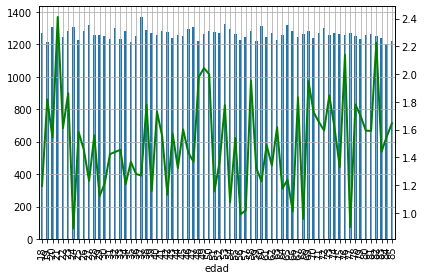

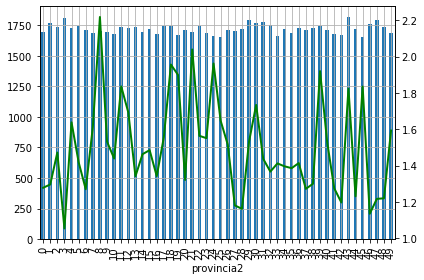

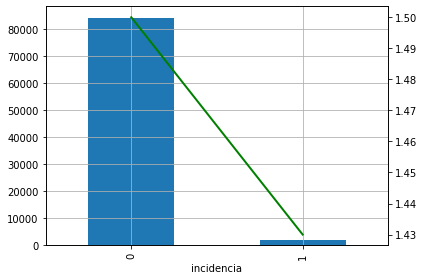

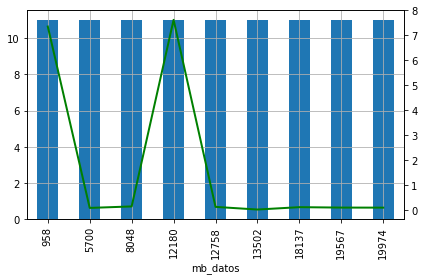

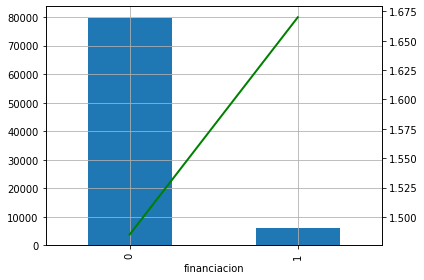

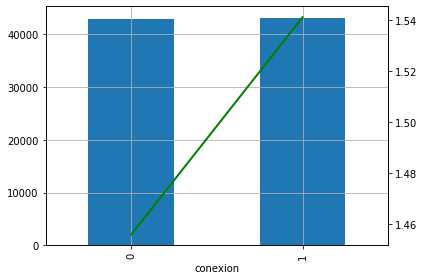

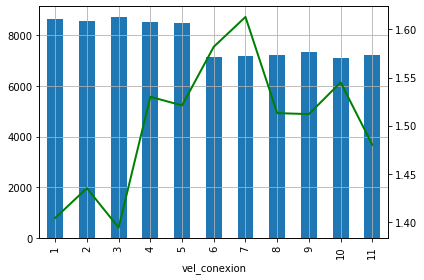

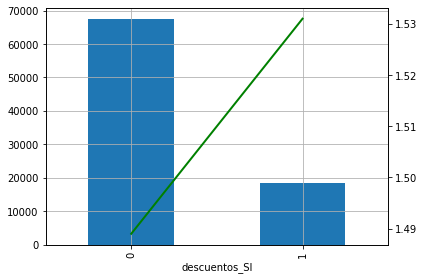

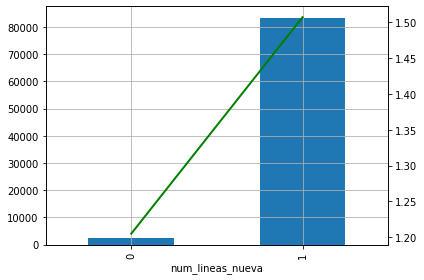

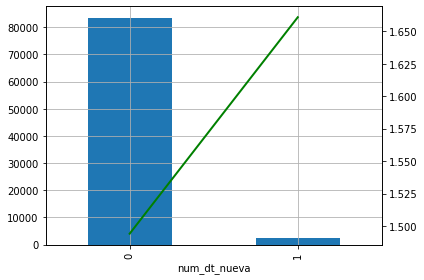

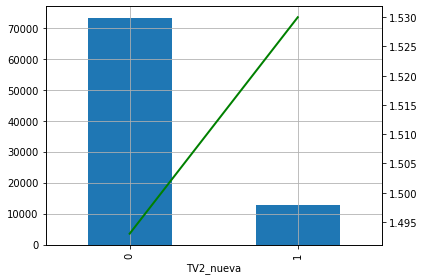

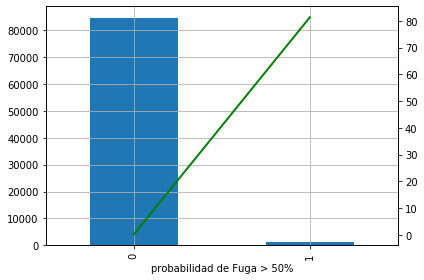

In [1937]:
# Visualizamos gráficas para analizar las variables claves que hacen que los cliente tengan más probabilida de fuga
for i in df_enero2.columns:
    proporciones_final (i, 'probabilidad de Fuga', df_enero2)

In [1938]:
# Intercepto 
Reg_log.intercept_

array([-8.38867113])

In [1939]:
# Coeficientes
Reg_log.coef_

array([[ 1.86356984e-02,  5.60574247e-02, -2.83373809e-02,
         1.78959277e+00,  9.20702991e-03,  4.87200576e-05,
         4.37476304e-02,  1.58246578e-02, -4.00253535e-03,
        -2.25513497e+00, -2.23227132e-02, -3.82105928e-03,
        -4.32857681e-03, -4.70427438e+00,  1.78470859e-02,
         1.97404578e+00,  2.37254299e-03]])

Si el signo de los coeficientes del modelo es positivo (beta>0), incrementos en la variable independiente suponen incrementos en la probabilidad de pertenecer al grupo de interés (y=1). 

Y, en sentido contrario, si los coeficientes de la variable independiente son negativos (beta<0), incrementos en la variable independiente hacen disminuir la probabilidad de pertenecer al grupo de interés (y=1).

In [1940]:
# Odd-ratios (riesgos relativos)
np.exp(Reg_log.coef_)

array([[1.01881043, 1.05765842, 0.97206036, 5.98701389, 1.00924954,
        1.00004872, 1.04471867, 1.01595053, 0.99600546, 0.10485939,
        0.97792459, 0.99618623, 0.99568078, 0.00905648, 1.0180073 ,
        7.19974626, 1.00237536]])

In [1941]:
df_enero.dtypes

edad                  int64
facturacion         float64
provincia2            int32
incidencia            int64
num_llamad_ent        int64
num_llamad_sal        int64
mb_datos              int64
seg_llamad_ent        int64
seg_llamad_sal        int64
financiacion          int64
conexion              int64
vel_conexion          int64
meses_antiguedad      int32
descuentos_SI         uint8
num_lineas_nueva      int64
num_dt_nueva          int64
TV2_nueva             int64
dtype: object

El odd-ratio es el cociente de la probabilidad de pertenecer al grupo de interés (y=1) entre la probabilidad de no pertenecer al grupo de interés (y=0).

En la regresión logística el odd-ratio es la exponencial de los coeficientes del modelo de regresión logística.

Cuando el odd-ratio es mayor a 1, la probabilidad de pertenecer al grupo de interés (y=1) incrementa; cuando es menor a 1, tal probabilidad de pertenecer al grupo de interés (y=1) disminuye.

#### Análisis por cada variables

Edad: En las gráficas de visualización generadas podemos observar que existen dos picos pronunciados en clientes de 21 años y en clientes de 81-82 años, éstos presentan una mayor probabilidad de fuga. Además, observando los coeficientes y el odd-ratio de nuestro modelo de regresión logística observamos que su beta es positiva y el odd-ratio de 1.01881; es decir, incrementos en la variable ‘edad’ hacen aumentar la probabilidad de fuga y, además, por cada año que una persona tenga un año más se incrementa la probabilidad de fuga en un 1,88%.

Facturación: su beta es positiva y el odd-ratio de 1.05765842; es decir, incrementos en la variable ‘facturacion’ hacen aumentar la probabilidad de fuga y, además, por cada aumento unitario en ‘facturacion’, la probabilidad de fuga aumenta en un 5,76%.

Incidencia: En función de la gráfica, los clientes sin reportar ninguna incidencia tienen más probabilidad de irse de la compañía aunque, sin embargo, hemos de percatarnos que la mayoría de los clientes de nuestro dataset no han reportado incidencias, muy pocos clientes han reportado alguna incidencia. El coeficiente beta es positivo y el odd-ratio es de 5.98701389; por tanto, el hecho de reportar incidencias no incrementa la probablidad de fuga de la compañía.

Número de llamadas entrantes: Los clientes con un mayor número de llamadas entrantes tienen una mayor probabilidad de irse de la compañía, el odd-ratio es de 1.00924954, es decir, aumentos unitarios en esta variable incrementan la probabilidad de fuga en 0,92%.

Número de llamadas salientes: Los clientes con un mayor número de llamadas salientes también tienen una mayor probabilidad de irse de la compañía. Un aumento unitario en la variable 'num_llamad_sal' produce un aumento de la probabilidad de irse pero sólo en un 0,004%, el odd-ratio es 1,00004872.

Mb datos: En el caso del total de mb de los datos consumidos en todas las líneas de un cliente, podemos observar en la gráfica la existencia de dos picos en 958mb y en 12180mb, en esos puntos la probabilidad de fuga de los clientes es mayor, quizá sea debido a alguna particularidad del tipo de paquete o plan contratado por los mismos y ofertado por la compañía telefónica. Un mayor consumo de datos, contribuye a un aumento en la probabilidad de irse según su coeficiente beta, el odd-ratio es de 1.04471867, un incremento unitario de ‘mb_datos’ produce un incremento en la probabilidad de irse de un 4,47%.

Segundos consumidos en llamadas entrantes: Los clientes que presentan un mayor número de llamadas entrantes tiene más probabilidad de irse de la compañía. El odd-ratio es de 1.01595053; es decir, aumentos unitarios en 'seg_llamad_ent' aumenta la probabilidad de irse en un 1,59%.

Segundos consumidos en llamadas salientes: Su odd-ratio del 0.99600546 indica que aumentos unitarios en seg_llamad_sal' disminuyen la probabilidad de fuga de los clientes.

Financiación: A la luz de la gráfica, los clientes que tienen financiado algún terminal (aunque no son mucho de los clientes de nuestro set de datos) tienen una mayor probabilidad de fuga. Aunque no es relevante puesto que la beta de esta variable es negativa y su odd-ratio está por debajo de 1, siendo 0.10485939.

Conexión: Siendo ADSL=1 y FIBRA=0. Los clientes que tienen ADLS tienen más probabilidad de irse de la compañía. Aunque, si bien, la beta de esta variable es negativa y su odd-ratio menor a 1 (0.97792459). La variable ‘conexión’ no afecta positivamente en la fuga de clientes. 

Velocidad de conexión: En cuanto a la velocidad de conexión a internet, a la luz de la gráfica podemos observar que los clientes que tienen 50mb, 35mb, 30mb, 25mb, 20mb y 15mb tiene mayor probabilidad de fuga. Sin embargo, el coeficiente beta es negativo, y el odd-ratio de 0.99618623.

Meses de antigüedad: Llevar más tiempo en la compañía telefónica implica una disminución de la probabilidad de fuga de la misma a la luz del coeficiente beta y el odd-ratio del 0.99568078.

Descuentos: Aunque son muy pocos clientes los que tiene activado algún descuento en la compañía, observando la gráfica poder indicar que los clientes que tienen activo algún tipo de descuento tiene mayor probabilidad de fuga. Si bien, esta variable contribuye negativamente al incremento de la fuga con un odd-ratio de 0.00905648.

Número de líneas móviles contratadas: Los clientes que tienen más de una línea móvil contratada tienen más probabilidad de irse de la compañía, además éstos clientes son la mayoría de clientes de nuestra compañía. El odd-ratio es de 1.0180073, lo que indica que incrementos unitarios en esta variable suponen un aumento en la probabilidad de fuga de un 1,80%.

Número de líneas en impago: Según lo graficado, los clientes con alguna línea en impago, que son el menor número de ellos en el conjunto de clientes de nuestro dataset, tienen una mayor probabilidad de fuga de la compañía. Además, el odd-ratio para esta varia es de 7,19974626; es decir, tener líneas en impago contribuye muy positivamente a la fuga de la compañía. 

TV: El valor 0 considera a los clientes que tienen contratado el paquete ‘tv-familiar’ o ‘tv-futbol’. Los clientes que tienen contratado el paquete ‘tv-total’, que son los representados por el valor 1 y que son el menor número de clientes en nuestro conjunto de datos de enero, tienen una mayor probabilidad de fuga de la compañía. Además, y según el odd-ratio de 1.00237536 de esta variable, tener contratado el paquete ‘tv-total’ aumenta la probabilidad de fuga en un 0,23%.

En conclusión, tras lo expuesto y explicado, podemos indicar que las variables que más influyen en el aumento de la probabilidad de fuga de los clientes son:

- 'edad'.
- 'facturacion'.
- 'num_llamad_ent', número de llamadas entrantes.
- 'num_llamad_sal', número de llamadas salientes.
- 'mb_datos', mb de los datos consumidos en todas las líneas contratadas por un cliente.
- 'seg_llamad_ent', segundos consumidos en llamadas entrantes.
- 'num_lineas_nueva', número de líneas móviles contratadas.
- 'num_dt_nueva, número de líneas en impago. Esta es una de las variables más influyentes en el incremento de la probablidad de fuga.
- 'TV2_nueva', en concreto tener contratado el paquete 'tv_total' frente a 'tv_familiar' o 'tv_futbol'.